## Analysis of "How YouTube leads privacy-seeking users away from reliable information" 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy as sp
import os
import json
from datetime import date
import numpy as np
import math
import ternary
from scipy import stats

from ternary.helpers import project_point
from matplotlib.lines import Line2D

import six

In [2]:
#### 
# Some definitions 
####

# Sequence bin size
BINSIZE = 2

def auxSem(std, size):
    return std/math.sqrt(size*BINSIZE)

In [3]:
# Color for each different experiment parameter
colorMap = {
  'logged': 'blue',
  'normal': 'green',
  'private': 'orange',
  'tor': 'red', 
  'top movie': 'turquoise',
  'bottom movie': 'crimson',
  'browsing news': 'indigo',
  'none': 'tomato',
  'before': 'tomato',
  'after': 'indigo',
  'all': 'black',
  'extreme': 'red',
  'neutral' : 'green',
  'trustable' : 'blue',
    'April the Giraffe': 'blue',
    'Bitcoin Price': 'orange',
    'DACA': 'green',
    'Hurricane Harvey': 'red',
    'Hurricane Irma': 'purple',
    'Hurricane Jose': 'brown',
    'Hurricane Maria': 'pink',
    'Las Vegas shooting': 'gray',
    'North Korea': 'yellow',
    'Solar Eclipse': 'lightblue' 
  }  

In [4]:
# Loading the pre-processed and sampled files to pandas dataframe

directory='data' 
filename1 = 'dataSampledQuerySetRes.csv'
filename2 = 'dataSampledQuerySetResPol.csv'

file = os.path.join(directory, filename1)
dataYT = pd.read_csv(file)

file = os.path.join(directory, filename2)
dataYTPol = pd.read_csv(file)

# filename sufix to save figures names according to part of data used
filesufix1 = "querysetres"
filesufix2 = "querysettop"
filesufix3 = "querysetpol"


In [5]:
# Creating first point "isolated"
dataYT['bin'] = dataYT.apply(lambda x: int(int(x['seq']-1)/BINSIZE)+1, axis=1)
tmp = dataYT[dataYT['seq']== 1].copy()
tmp['bin'] = 0
dataYT = dataYT.append(tmp)

dataYTPol['bin'] = dataYTPol.apply(lambda x: int(int(x['seq']-1)/BINSIZE)+1, axis=1)
tmp = dataYTPol[dataYTPol['seq']== 1].copy()
tmp['bin'] = 0
dataYTPol = dataYTPol.append(tmp)

In [6]:
# Printing all data columns
dataYT.columns

Index(['index', 'Unnamed: 0', 'category', 'channel', 'channel_id', 'clar_link',
       'clarify', 'date', 'datePublish', 'depth', 'dislikes', 'filename', 'id',
       'id,title,channel,channel_id,classification', 'key', 'lenght',
       'license', 'likes', 'order', 'preaction', 'rec_qt', 'recommendations',
       'response', 'search', 'setting', 'subscribers', 'title', 'verified',
       'views', 'classification', 'ord', 'verify', 'dateDays', 'clas',
       'handsQt', 'likeRatio', 'dislikeRatio', 'dislikePerView', 'likePerView',
       'handsPerView', 'viewsPerDay', 'handsPerDay', 'viewsPerSubscribers',
       'ind', 'seq', 'seq_max', 'bin'],
      dtype='object')

In [7]:
# Creating boolean variable for each class - auxiliary to future computation of proportion mix

# Main data
dataYT['clas-1'] = np.where((dataYT['clas'] == -1 ), 1, 0)
dataYT['clas0'] = np.where((dataYT['clas'] == 0 ), 1, 0)
dataYT['clas1'] = np.where((dataYT['clas'] == 1 ), 1, 0)

# Data sampled also by response
dataYTPol['clas-1'] = np.where((dataYTPol['clas'] == -1 ), 1, 0)
dataYTPol['clas0'] = np.where((dataYTPol['clas'] == 0 ), 1, 0)
dataYTPol['clas1'] = np.where((dataYTPol['clas'] == 1 ), 1, 0)

In [8]:
# data with just "top item" response
dataYTTop = dataYT[dataYT.response == 'top movie']

### Data Caracterization 

In [9]:
## Function to render dataframe as table figure
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [10]:
# Getting data sequence average data per bin
dataSeqAvgAll = dataYT.groupby(['search', 'setting', 'preaction', 'response','date', 'filename','bin'])['clas','clas-1', 'clas0', 'clas1'].mean().unstack().fillna(0)
#ScoreClas = dataYT.groupby(['search', 'setting', 'preaction', 'response','date', 'filename', 'bin'])['clas'].mean().unstack().fillna(0)
dataSeqAvgAll = pd.DataFrame(dataSeqAvgAll)
dataSeqAvgAll.reset_index(inplace=True)

In [11]:
# Number of sequences per experiment parameter
dataSeqAvgAll.groupby(['setting', 'response', 'search']).size().head(10)

setting  response      search            
logged   bottom movie  April the Giraffe     17
                       Bitcoin Price         20
                       DACA                  18
                       Hurricane Harvey      33
                       Hurricane Irma        38
                       Hurricane Jose        24
                       Hurricane Maria       19
                       Las Vegas shooting    44
                       North Korea           24
                       Solar Eclipse         19
dtype: int64

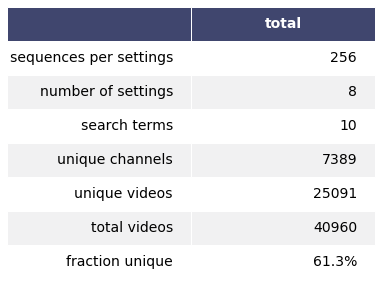

In [12]:
## Getting general information and generating table
MINV = dataSeqAvgAll.groupby(['setting', 'response']).size().min()

SET = len(dataSeqAvgAll['setting'].unique())*len(dataSeqAvgAll['response'].unique())
CHAN = len(dataYT['channel_id'].unique())
SER = len(dataYT['search'].unique())
VID = len(dataYT['id'].unique())
TOTAL = len(dataSeqAvgAll.index)*20

dictionary = {' ': ["sequences per settings", "number of settings", "search terms", "unique channels", "unique videos", "total videos", "fraction unique"], 'total': [MINV, SET, SER, CHAN, VID, MINV*20*SET, str(round((VID/(MINV*20*SET))*100,1))+"%"]}
info  = pd.DataFrame(dictionary)

render_mpl_table(info, header_columns=0, col_width=3.3)
fig = plt.gcf()
fig.savefig("figures/fig001" + filesufix1 +"_tableInfo.eps", format='eps', bbox_inches='tight', pad_inches=0.01)

In [13]:
# Auxiliary function to create bins with log_2 size
def binLog(val):
    result = 0
    tmp = 1
    while (tmp < val):
        tmp *= 2
        result += 1
    return np.power(2, result)

# Auxiliary function to plot proportional bars with colors and distribution (Figure 2)
def log2histogram(data, column, filename):
    
    ch_aux = data.copy()
    
    ch_aux['bins'] = ch_aux.apply(lambda x: binLog(x[column]), axis=1)

    ch_aux['clas'] = np.where(ch_aux['clas']== -1, "trustable", ch_aux['clas'])
    ch_aux['clas'] = np.where(ch_aux['clas']== "1", "extreme", ch_aux['clas'])
    ch_aux['clas'] = np.where(ch_aux['clas']== "0", "neutral", ch_aux['clas'])
   
    tmp = ch_aux.groupby(['bins']).size()
    tmp = pd.DataFrame(tmp)
    tmp.reset_index(inplace=True)
    tmp.columns = ['bins', 'total']
   
    tmp2 = ch_aux.groupby(['bins', 'clas']).size()
    tmp2 = pd.DataFrame(tmp2)
    tmp2.reset_index(inplace=True)
    tmp2.columns = ['bins', 'clas', 'value']
    
    tmp2 = pd.merge(tmp2, tmp, on=['bins'], how='inner')
    tmp2['val'] = tmp2['value']/tmp2['total']
            
    tmp3 = tmp2.pivot(index='bins', columns='clas', values='val')
    
    plt.rc('font', size=7) 
    fig, ax = plt.subplots(figsize=(4,2))
    plt.rc('font', size=7) 
    
    ax = tmp3.plot(kind='bar',ax=ax, stacked=True, color=[colorMap['extreme'],colorMap['neutral'], colorMap['trustable']])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    ax.set_ylim(0, 1.1)
    
    #annotate values over the bar
    x_offset = -0.05
    y_offset = 0.03
    
    vet = tmp['total']
    #print(vet)
    i = 0
    for p in ax.patches:
        if i < len(vet):
            b = p.get_bbox()
            #print(b)
            val = int(vet[i])
            ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, 1 + y_offset))
        i += 1
   
    plt.xlabel('counting')
    plt.ylabel('proportion by category')
    plt.rc('font', size=7) 
    fig = plt.gcf()
    fig.savefig(filename, format='eps', bbox_inches='tight', pad_inches=0.01)

POP 75% 1.0
POP 80% 2.0
POP 90% 3.0
POP 95% 4.0
POP 98% 8.0


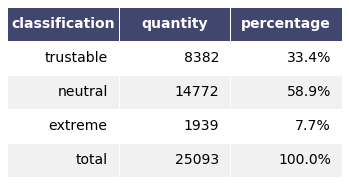

In [14]:
# Getting general information about the videos 
video_info = dataYT.groupby(['channel_id', 'id','clas'])['ind'].count()
video_info = pd.DataFrame(video_info)
video_info.reset_index(inplace=True)
video_info.columns = ['channel_id', 'id', 'clas', 'qtc']

# Creating popularity of video variables
POP75 = video_info.qtc.quantile(0.75)
print("POP 75% " + str(POP75))
video_info['popular75'] = np.where((video_info['qtc'] > POP75 ), 1, 0)
POP8 = video_info.qtc.quantile(0.8)
print("POP 80% " + str(POP8))
video_info['popular8'] = np.where((video_info['qtc'] > POP8 ), 1, 0)
POP9 = video_info.qtc.quantile(0.9)
print("POP 90% " + str(POP9))
video_info['popular9'] = np.where((video_info['qtc'] > POP9 ), 1, 0)
POP95 = video_info.qtc.quantile(0.95)
print("POP 95% " + str(POP95))
video_info['popular95'] = np.where((video_info['qtc'] > POP95 ), 1, 0)
POP98 = video_info.qtc.quantile(0.98)
print("POP 98% " + str(POP98))
video_info['popular98'] = np.where((video_info['qtc'] > POP98 ), 1, 0)
video_info['unpopular'] = np.where((video_info['qtc'] == 1 ), 1, 0)


# getting aggregating information
agg = video_info.groupby('clas').size()
agg = pd.DataFrame(agg)
agg.reset_index(inplace=True)
agg.columns = ['classification', 'quantity']
agg['classification'] = np.where(agg['classification']== -1, "trustable", agg['classification'])
agg['classification'] = np.where(agg['classification']== "1", "extreme", agg['classification'])
agg['classification'] = np.where(agg['classification']== "0", "neutral", agg['classification'])

total = sum(agg['quantity'])
agg = pd.concat([agg, pd.DataFrame({'classification':["total"], 'quantity':[total]}, index = [len(agg.index)])])

agg['percentage'] = agg.apply(lambda x: str(round((x['quantity']/total)*100, 1))+"%", axis=1)

# Get figure with table with videos information
render_mpl_table(agg, header_columns=0, col_width=2.0)
fig = plt.gcf()
fig.savefig("figures/fig107" + filesufix1 + "_tableVideos.eps", format='eps', bbox_inches='tight', pad_inches=0.01)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


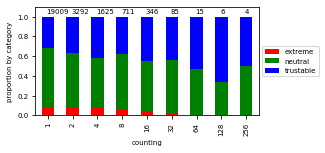

In [15]:
## Figure 2:
# Binned counts of the number of appearances of each video, and 
# the classification of videos in each bin
log2histogram(video_info, 'qtc', "figures/fig201" + filesufix1 + "_videosbarlogvid.eps")

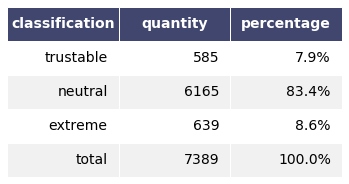

In [16]:
# Getting channel information 
channel_info = dataYT.groupby(['channel_id', 'clas'])['ind'].count()
channel_info = pd.DataFrame(channel_info)
channel_info.reset_index(inplace=True)
channel_info.columns = ['channel_id', 'clas','qtc']

 # getting aggregating information
agg = channel_info.groupby('clas').size()
agg = pd.DataFrame(agg)
agg.reset_index(inplace=True)
agg.columns = ['classification', 'quantity']
agg['classification'] = np.where(agg['classification']== -1, "trustable", agg['classification'])
agg['classification'] = np.where(agg['classification']== "1", "extreme", agg['classification'])
agg['classification'] = np.where(agg['classification']== "0", "neutral", agg['classification'])

total = sum(agg['quantity'])
agg = pd.concat([agg, pd.DataFrame({'classification':["total"], 'quantity':[total]}, index = [len(agg.index)])])

agg['percentage'] = agg.apply(lambda x: str(round((x['quantity']/total)*100, 1))+"%", axis=1)

# Get figure with table with channel info information
render_mpl_table(agg, header_columns=0, col_width=2.0)
fig = plt.gcf()
fig.savefig("figures/fig07" + filesufix1 + "_tableChannels.eps", format='eps', bbox_inches='tight', pad_inches=0.01)



### Analysis over the default YouTube video selection (top item) 

In [17]:
# Getting data sequence average data per bin (top item video selection)
dataSeqAvg = dataYTTop.groupby(['search', 'setting', 'preaction', 'response','date', 'filename','bin'])['clas','clas-1', 'clas0', 'clas1'].mean().unstack().fillna(0)
dataSeqAvg = pd.DataFrame(dataSeqAvg)
dataSeqAvg.reset_index(inplace=True)
dataSeqAvg.head()

search setting      preaction   response        date  \
bin                                                                    
0    April the Giraffe  logged  browsing news  top movie  2018-10-31   
1    April the Giraffe  logged  browsing news  top movie  2018-11-01   
2    April the Giraffe  logged  browsing news  top movie  2018-11-03   
3    April the Giraffe  logged  browsing news  top movie  2018-11-07   
4    April the Giraffe  logged  browsing news  top movie  2018-12-05   

                                              filename clas                 \
bin                                                       0    1    2    3   
0    data-browListNl0-April the Giraffe_2018-10-31_...  0.0  0.0 -0.5  0.0   
1    data-browListNl0-April the Giraffe_2018-11-01_...  0.0  0.0  0.0  0.0   
2    data-browListNl0-April the Giraffe_2018-11-03_...  0.0  0.0  0.0  0.0   
3    data-browListNl0-April the Giraffe_2018-11-07_...  0.0 -0.5 -0.5  0.0   
4    data-browListNl0-April the Giraffe_2018-12-05_...  0.0  0.0  0.0  0.0   

     ... clas1                                               
bin  ...     1    2    3    4    5    6    7    8    9   10  
0    ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.5  0.0  
1    ...   0.0  0.5  0.0  0.5  1.0  0.5  0.0  0.5  0.0  0.0  
2    ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3    ...   0.0  0.0  0.0  0.5  0.0  0.0  0.0  0.0  0.0  0.0  
4    ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 50 columns]

In [18]:
# Auxiliary plot functions

# Plots by columns: 'col'
def plotCol(data, col, title, output):
    data0 = data.copy()
    fig, ax = plt.subplots(figsize=(4,2))    # 1
    data0['bin'] = data0['bin'].astype(int)
    ax.set_xlim(-1, 21)
    ax.locator_params(integer=True)
    plt.rc('font', size=7)
   
    fig.tight_layout()
    for key, group in data0.groupby(col):
        group.plot('bin', 'mean', yerr='sem', label=key, ax=ax, color=colorMap[key])   # 2
        
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)
    
    plt.rc('font', size=7) 
    plt.xlabel('video sequence')
    plt.ylabel('classification average')
    fig = plt.gcf()
    fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
   
    plt.show()
    
# Plot a simple analysis by column given a group    
def simpleAnalysis(dataF2, column, group):
 
    # Getting data sequence average data per bin
    dataFAux = dataF2.groupby(['search', 'setting', 'preaction', 'response','date', 'filename', 'bin'])[column].mean().unstack().fillna(0)
    dataFAux = pd.DataFrame(dataFAux)
    dataFAux.reset_index(inplace=True)
    dataFAux.head()
    
    tmp5 = dataFAux.groupby([group]).mean().unstack()
    tmp5 = pd.DataFrame(tmp5)
    tmp5.reset_index(inplace=True) 
    tmp5.columns = ['bin', group, 'mean']
    
    tmp05 = dataFAux.mean()
    tmp05 = pd.DataFrame(tmp05)
    tmp05.reset_index(inplace=True) 
    tmp05.columns = ['bin', 'mean']
    tmp05[group] = 'all'

    tmp4 = dataFAux.groupby([group]).std().unstack()
    tmp4 = pd.DataFrame(tmp4)
    tmp4.reset_index(inplace=True) 
    tmp4.columns = ['bin', group, 'std']

    tmp04 = dataFAux.std()
    tmp04 = pd.DataFrame(tmp04)
    tmp04.reset_index(inplace=True) 
    tmp04.columns = ['bin', 'std']
    tmp04[group] = 'all'
    
    tmp4 = tmp4.append(tmp04)
    tmp5 = tmp5.append(tmp05)
    
    tmp = pd.merge(tmp4, tmp5, on=['bin', group], how='inner')

    tmp3 = dataFAux.groupby([group]).size()
    tmp3 = pd.DataFrame(tmp3)
    tmp3.reset_index(inplace=True) 
    tmp3.columns = [group, 'size']
    alls = tmp3['size'].sum()
    

    tmp0 = pd.merge(tmp, tmp3, on=[group], how='left')
    tmp0['size'] = np.where(tmp0[group]== 'all', alls, tmp0['size'])
    tmp0['sem'] = tmp0.apply(lambda x: auxSem(x['std'], x['size']), axis=1)
    tmp0['sem'] = np.where((tmp0['bin']==0), tmp0['sem']*math.sqrt(BINSIZE), tmp0['sem'])
    tmp0['bin'] = np.where((tmp0['bin']==0), 0 , tmp0['bin']*BINSIZE )

    plotCol(tmp0, group, "", "figures/fig410" + filesufix2 + "_geral"+ column + group + "Lines.eps")
      

Plotting overall by clas


/Users/larissapspinelli/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


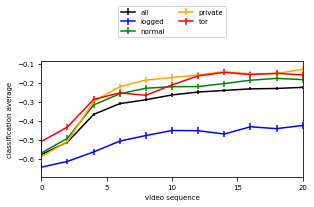

Plotting overall by views


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


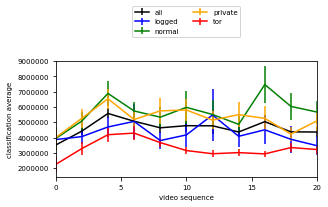

Plotting overall by lenght


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


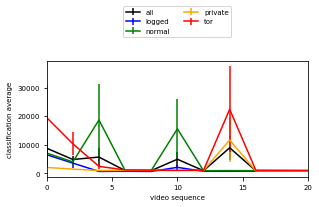

Plotting overall by verify


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


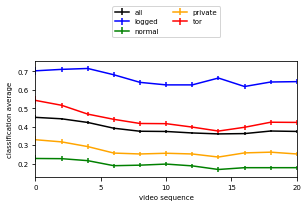

Plotting overall by likes


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


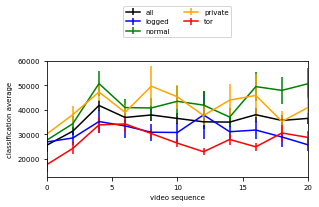

Plotting overall by dislikes


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


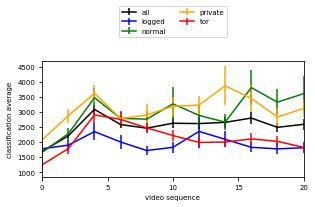

Plotting overall by subscribers


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


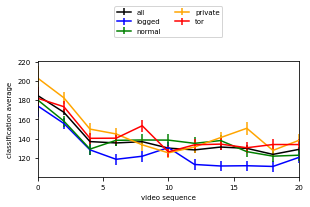

Plotting overall by dateDays


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


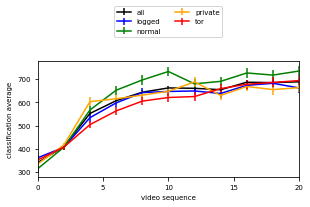

Plotting overall by handsQt


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


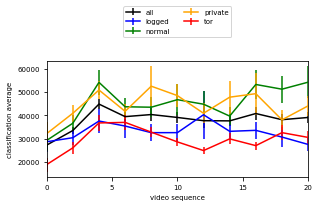

Plotting overall by likeRatio


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


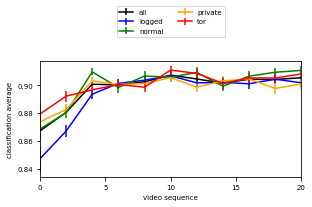

Plotting overall by dislikeRatio


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


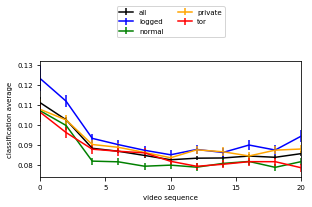

Plotting overall by dislikePerView


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


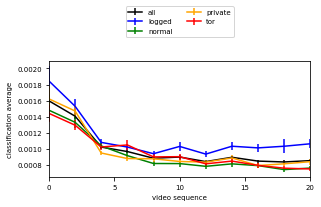

Plotting overall by likePerView


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


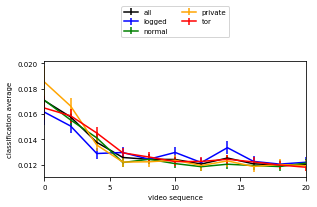

Plotting overall by handsPerView


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


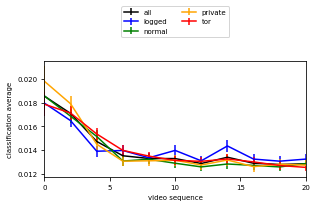

Plotting overall by viewsPerDay


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


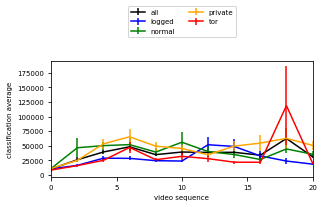

Plotting overall by handsPerDay


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


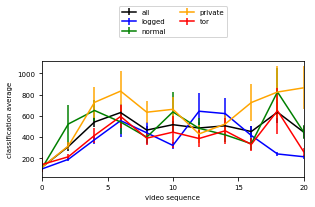

Plotting overall by viewsPerSubscribers


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


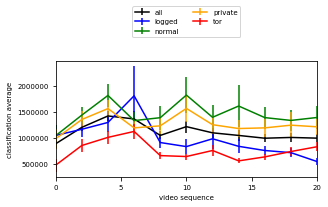

In [19]:
## Exploring changes over sequence over all feature colected 

# Plotting overall changes over times per column
cols = ['clas', 'views', 'lenght', 'verify', 'likes', 'dislikes', 'subscribers', 'dateDays','handsQt', 'likeRatio', 'dislikeRatio', 'dislikePerView', 'likePerView', 'handsPerView',   'viewsPerDay',   'handsPerDay','viewsPerSubscribers']
for col in cols:
    print("Plotting overall by " + col)
    simpleAnalysis(dataYT, col, 'setting')

In [20]:
# Plot a simple analysis by column given a group    
def simpleAnalysis2(dataF2, column, group):
 
    # Getting data sequence average data per bin
    dataFAux = dataF2.groupby(['search', 'setting', 'preaction', 'response','date', 'filename', 'bin'])[column].mean().unstack().fillna(0)
    dataFAux = pd.DataFrame(dataFAux)
    dataFAux.reset_index(inplace=True)
    dataFAux.head()
    
    tmp5 = dataFAux.groupby([group]).mean().unstack()
    tmp5 = pd.DataFrame(tmp5)
    tmp5.reset_index(inplace=True) 
    tmp5.columns = ['bin', group, 'mean']
    
    tmp05 = dataFAux.mean()
    tmp05 = pd.DataFrame(tmp05)
    tmp05.reset_index(inplace=True) 
    tmp05.columns = ['bin', 'mean']
    tmp05[group] = 'all'

    tmp4 = dataFAux.groupby([group]).std().unstack()
    tmp4 = pd.DataFrame(tmp4)
    tmp4.reset_index(inplace=True) 
    tmp4.columns = ['bin', group, 'std']

    tmp04 = dataFAux.std()
    tmp04 = pd.DataFrame(tmp04)
    tmp04.reset_index(inplace=True) 
    tmp04.columns = ['bin', 'std']
    tmp04[group] = 'all'
    
    #tmp = tmp4.append(tmp04)
    #tmp = tmp5.append(tmp05)
    
    tmp = pd.merge(tmp4, tmp5, on=['bin', group], how='inner')

    tmp3 = dataFAux.groupby([group]).size()
    tmp3 = pd.DataFrame(tmp3)
    tmp3.reset_index(inplace=True) 
    tmp3.columns = [group, 'size']
    alls = tmp3['size'].sum()
    

    tmp0 = pd.merge(tmp, tmp3, on=[group], how='left')
    #tmp0['size'] = np.where(tmp0[group]== 'all', alls, tmp0['size'])
    tmp0['sem'] = tmp0.apply(lambda x: auxSem(x['std'], x['size']), axis=1)
    tmp0['sem'] = np.where((tmp0['bin']==0), tmp0['sem']*math.sqrt(BINSIZE), tmp0['sem'])
    tmp0['bin'] = np.where((tmp0['bin']==0), 0 , tmp0['bin']*BINSIZE )

    plotCol(tmp0, group, "", "figures/fig411" + filesufix2 + "_geral"+ column + group + "Lines.eps")
   




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


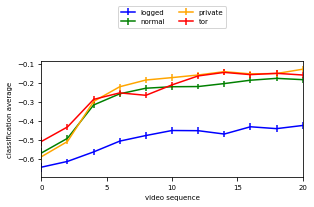

In [21]:
simpleAnalysis2(dataYT, 'clas', 'setting')

1024


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

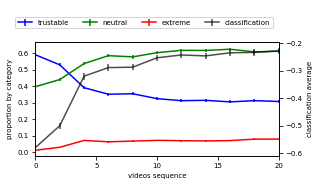

In [22]:
## 
# General Top Item analysis
##

# Figure 3a: Ploting classification proportions and unreability score 

tmp01 = dataSeqAvg.mean()
tmp01 = pd.DataFrame(tmp01)
tmp01.reset_index(inplace=True) 
tmp01.columns = ['lab', 'bin', 'mean']

tmp02 = dataSeqAvg.std()
tmp02 = pd.DataFrame(tmp02)
tmp02.reset_index(inplace=True) 
tmp02.columns = ['lab','bin','std']

seqOverall = pd.merge(tmp01, tmp02, on=['lab','bin'], how='inner')
seqOverall['bin'] = np.where((seqOverall['bin']==0), 0 , seqOverall['bin']*BINSIZE )


tmp03 = len(dataSeqAvg.index)
print(tmp03)

seqOverall['sem'] = seqOverall.apply(lambda x: auxSem(x['std'], tmp03), axis=1)

fig, ax = plt.subplots(figsize=(4,2))   # 1
plt.rc('font', size=7)
seqOverall['bin'] = seqOverall['bin'].astype(int)
ax.set_xlim(1, 21)
ax.locator_params(integer=True)
ax2 = ax.twinx()

fig.tight_layout()

tmp03 = seqOverall[seqOverall['lab']=='clas']
tmp03.plot('bin', 'mean', yerr='sem', ax=ax2, label='classification', color=colorMap['all'], alpha=0.7)

tmp02 = seqOverall[seqOverall['lab']=='clas-1']
tmp02.plot('bin', 'mean', yerr='sem', ax=ax, label='trustable', color=colorMap['trustable'])

tmp00 = seqOverall[seqOverall['lab']=='clas0']
tmp00.plot('bin', 'mean', yerr='sem', ax=ax, label='neutral', color=colorMap['neutral'])

tmp01 = seqOverall[seqOverall['lab']=='clas1']
tmp01.plot('bin', 'mean', yerr='sem', ax=ax, label='extreme', color=colorMap['extreme'])

plt.xlabel('videos sequence')
ax2.set_xlabel('videos sequence')
ax.set_xlabel('videos sequence')

ax.set_ylabel('proportion by category')
ax2.set_ylabel('classification average')

ax.get_legend().remove()
ax2.get_legend().remove()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)

plt.rc('font', size=7) 
plt.xlabel('videos sequence')
fig = plt.gcf()

output =  "figures/fig007w" + filesufix2 + "_overallClassLines.eps"
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

1024


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


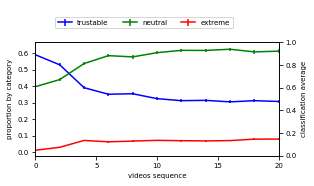

In [23]:
## 
# General Top Item analysis
##

# Figure 3a: Ploting classification proportions and unreability score 

tmp01 = dataSeqAvg.mean()
tmp01 = pd.DataFrame(tmp01)
tmp01.reset_index(inplace=True) 
tmp01.columns = ['lab', 'bin', 'mean']

tmp02 = dataSeqAvg.std()
tmp02 = pd.DataFrame(tmp02)
tmp02.reset_index(inplace=True) 
tmp02.columns = ['lab','bin','std']

seqOverall = pd.merge(tmp01, tmp02, on=['lab','bin'], how='inner')
seqOverall['bin'] = np.where((seqOverall['bin']==0), 0 , seqOverall['bin']*BINSIZE )


tmp03 = len(dataSeqAvg.index)
print(tmp03)

seqOverall['sem'] = seqOverall.apply(lambda x: auxSem(x['std'], tmp03), axis=1)

fig, ax = plt.subplots(figsize=(4,2))   # 1
plt.rc('font', size=7)
seqOverall['bin'] = seqOverall['bin'].astype(int)
ax.set_xlim(1, 21)
ax.locator_params(integer=True)
ax2 = ax.twinx()

fig.tight_layout()

tmp03 = seqOverall[seqOverall['lab']=='clas']
#tmp03.plot('bin', 'mean', yerr='sem', ax=ax2, label='classification', color='white', alpha=0.7)

tmp02 = seqOverall[seqOverall['lab']=='clas-1']
tmp02.plot('bin', 'mean', yerr='sem', ax=ax, label='trustable', color=colorMap['trustable'])

tmp00 = seqOverall[seqOverall['lab']=='clas0']
tmp00.plot('bin', 'mean', yerr='sem', ax=ax, label='neutral', color=colorMap['neutral'])

tmp01 = seqOverall[seqOverall['lab']=='clas1']
tmp01.plot('bin', 'mean', yerr='sem', ax=ax, label='extreme', color=colorMap['extreme'])

plt.xlabel('videos sequence')
ax2.set_xlabel('videos sequence')
ax.set_xlabel('videos sequence')

ax.set_ylabel('proportion by category')
ax2.set_ylabel('classification average')

ax.get_legend().remove()
#ax2.get_legend().remove()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4)

plt.rc('font', size=7) 
plt.xlabel('videos sequence')
fig = plt.gcf()

output =  "figures/fig007a" + filesufix2 + "_overallClassLines.eps"
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
plt.show()

In [24]:
# Getting points to ternary plot

tmp0a = seqOverall[seqOverall['lab']=='clas']
tmp0t = seqOverall[seqOverall['lab']=='clas-1']
tmp0n = seqOverall[seqOverall['lab']=='clas0']
tmp0e = seqOverall[seqOverall['lab']=='clas1']

points = []
for b in tmp0n.bin:
    p0t = tmp0t[tmp0t['bin']== b]
    p0n = tmp0n[tmp0n['bin']== b]
    p0e = tmp0e[tmp0e['bin']== b]
    points.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)),float(round(p0e['mean'],3)) ))
print(points)



[(0.397, 0.591, 0.012), (0.44, 0.53, 0.03), (0.538, 0.391, 0.071), (0.585, 0.352, 0.063), (0.578, 0.354, 0.067), (0.604, 0.325, 0.072), (0.618, 0.312, 0.07), (0.617, 0.314, 0.068), (0.625, 0.305, 0.07), (0.608, 0.312, 0.079), (0.613, 0.308, 0.08)]


In [25]:
# Auxiliary functions to euclidean distante 

def eucliDistance3(p0, p1):
    return math.sqrt((p1[0]-p0[0])*(p1[0]-p0[0])+(p1[1]-p0[1])*(p1[1]-p0[1])+(p1[2]-p0[2])*(p1[2]-p0[2]))

def eucliDistance2(p0, p1):
    return math.sqrt((p1[0]-p0[0])*(p1[0]-p0[0])+(p1[1]-p0[1])*(p1[1]-p0[1]))
 

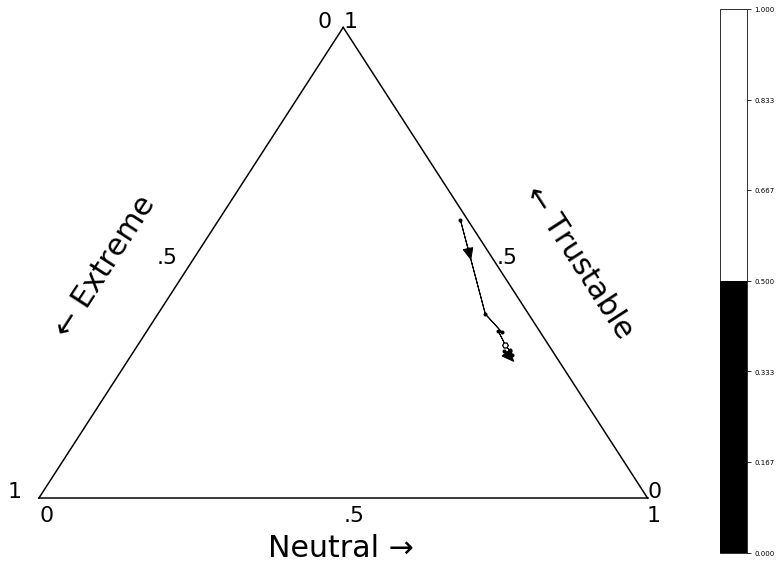

In [26]:
## Getting ternary plot with colormap
# Figure 3b: classification proportions shifts
import matplotlib.cm as cm

from matplotlib import colors
cmap = colors.ListedColormap(['black','white'])
bounds=[0, 1.0]
norm = colors.BoundaryNorm(bounds, cmap.N)

def classification(p):
    return round((p[2]-p[1]),2)

def classification2(p):
    if p[2]==1:
        return 0
    else:
        return 1

# Triangle setting 
pscale=10

scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 
figure, tax = ternary.figure(scale=pscale)
figure.set_size_inches(15, 10)
tax.boundary()
#tax.gridlines(multiple=0.125, color="lightgray", alpha=0.6, linestyle=':')

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)
#tax.set_title("Categories proportion over video sequence", fontsize=fontsizeL)

tax.heatmapf(classification2, boundary=True, style="triangular", cmap=cmap)
p0 = (0,0,0)

factor = 1
i=0
scaledpts = []
dis3 = []
for p in points:
    p1 = (p[0]*pscale,p[1]*pscale,p[2]*pscale)
    scaledpts.append(p1)
    pp1 = project_point(p1)
    plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color='black')
    
    if p0 != (0,0,0):
        pp0 = project_point(p0)
        d3 = eucliDistance3(p00, p)
        dis3.append(d3)
        #print(d3)
        if p == points[1] or p == points[-1] :
            factor = 1
            i += 1
        else:
            factor = 0
            if p == points[int(len(points)/2)]:
                plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color='black')
                plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
        plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor*pscale, head_length=0.02*factor*pscale,  fc='black', ec='black')
    p00 = p    
    p0 = p1
    
plt.axis('off')

# Plot initial and final guide lines    
# P (neutral, trustable, extreme)



# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()

pp1 = project_point(pu)
plt.text(pp1[0]-(pscale*off3), pp1[1], str(round(mine,1)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str(int(mint+scale)), fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4*pscale), pp1[1]+off1, str(int(mine+scale)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3*pscale, str(int(minn)), fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str(round(mint,1)), fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3*pscale, str(int(minn+scale)), fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4*pscale + off3), pp1[1], str("{:.1f}".format(round((mine+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3*pscale, str("{:.1f}".format(round((minn+scale)/2,1)))[1:], fontsize=fontsize1)

tax._redraw_labels()
#tax.scatter(scaledpts, s=(1000)) 

output =  "figures/fig007a" + filesufix2 + "_overallClassMapTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


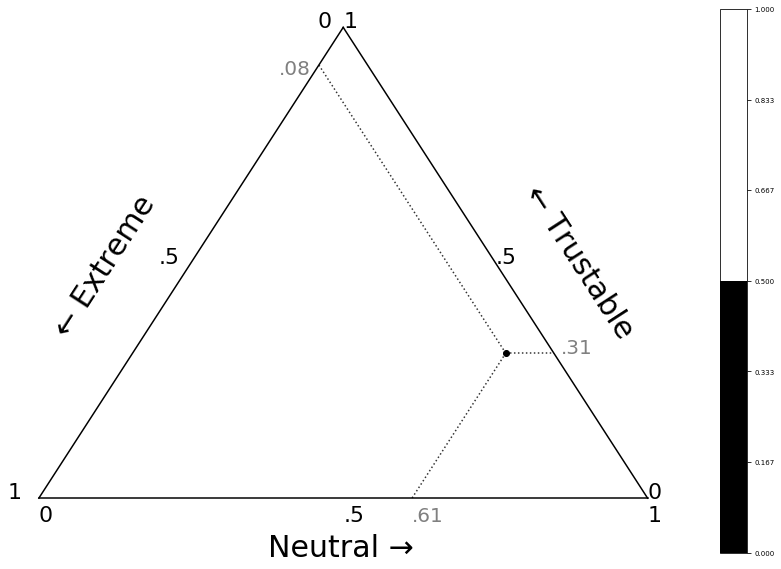

In [27]:
## Getting ternary plot with colormap
# Figure 3b: classification proportions shifts
import matplotlib.cm as cm

from matplotlib import colors
cmap = colors.ListedColormap(['black','white'])
bounds=[0, 1.0]
norm = colors.BoundaryNorm(bounds, cmap.N)

def classification(p):
    return round((p[2]-p[1]),2)

def classification2(p):
    if p[2]==1:
        return 0
    else:
        return 1

# Triangle setting 
pscale=100

scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 
figure, tax = ternary.figure(scale=pscale)
figure.set_size_inches(15, 10)
tax.boundary()
#tax.gridlines(multiple=0.125, color="lightgray", alpha=0.6, linestyle=':')

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)
#tax.set_title("Categories proportion over video sequence", fontsize=fontsizeL)

tax.heatmapf(classification2, boundary=True, style="triangular", cmap=cmap)
p0 = (0,0,0)

factor = 1
i=0
scaledpts = []
dis3 = []
if len(points) >0:
    p = points[-1]
    p1 = (p[0]*pscale,p[1]*pscale,p[2]*pscale)
    scaledpts.append(p1)
    pp1 = project_point(p1)
    plt.plot(pp1[0], pp1[1], marker='o', markersize=6, color='black')
    
    if p0 != (0,0,0):
        pp0 = project_point(p0)
        d3 = eucliDistance3(p00, p)
        dis3.append(d3)
        #print(d3)
        if p == points[1] or p == points[-1] :
            factor = 1
            i += 1
        else:
            factor = 0
            if p == points[int(len(points)/2)]:
                plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color='black')
                plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
        plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor*pscale, head_length=0.02*factor*pscale,  fc='black', ec='black')
    p00 = p    
    p0 = p1
    
plt.axis('off')

# Plot initial and final guide lines    
# P (neutral, trustable, extreme)

# Guide to initial point
p0 = scaledpts[-1]
pa0 = points[-1]
pp0 = project_point(p0)
#print(pp0)

# extreme
x = (p0[2])/2
y = (p0[2])*math.sqrt(3)/2
pp1 = project_point((0, pscale,0))
plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='black', linestyle=':', alpha=.8)
plt.text((pp1[0]-x-off4*pscale-off2*pscale), (pp1[1]-(y+1.6)), str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

# trustable
x = (pscale-p0[1])/2
y = (pscale-p0[1])*math.sqrt(3)/2
pp1 = project_point((0,pscale,0))
plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='black', linestyle=':', alpha=.8)
plt.text(pp1[0]+x+off1*pscale, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

# neutral
x = (p0[0])
pp1 = project_point((0,0,pscale))
#print(pp1)
plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='black', linestyle=':', alpha=.8)
plt.text(pp1[0]+x, pp1[1]-off3*pscale, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)




# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()

pp1 = project_point(pu)
plt.text(pp1[0]-(pscale*off3), pp1[1], str(round(mine,1)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str(int(mint+scale)), fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4*pscale), pp1[1]+off1, str(int(mine+scale)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3*pscale, str(int(minn)), fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str(round(mint,1)), fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3*pscale, str(int(minn+scale)), fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4*pscale + off3), pp1[1], str("{:.1f}".format(round((mine+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3*pscale, str("{:.1f}".format(round((minn+scale)/2,1)))[1:], fontsize=fontsize1)

tax._redraw_labels()
#tax.scatter(scaledpts, s=(1000)) 

output =  "figures/fig007b" + filesufix2 + "_overallClassMapTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()

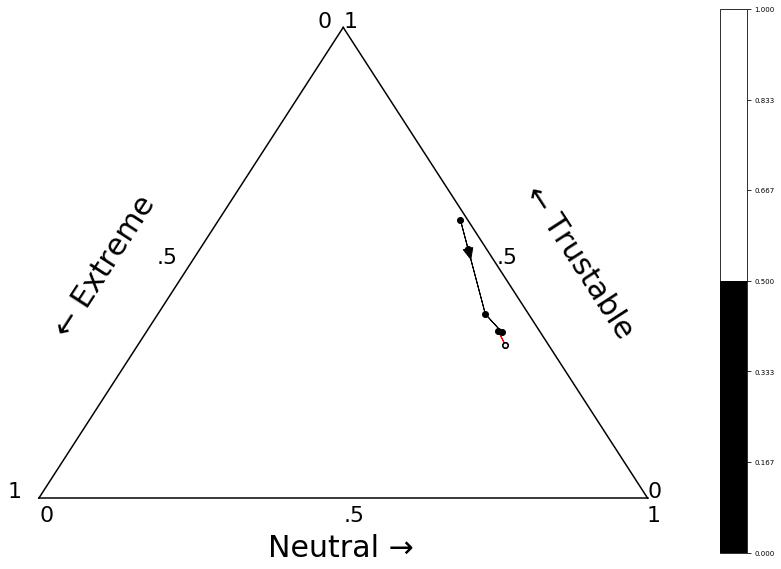

In [28]:
## Getting ternary plot with colormap
# Figure 3b: classification proportions shifts
import matplotlib.cm as cm

from matplotlib import colors
cmap = colors.ListedColormap(['black','white'])
bounds=[0, 1.0]
norm = colors.BoundaryNorm(bounds, cmap.N)

def classification(p):
    return round((p[2]-p[1]),2)

def classification2(p):
    if p[2]==1:
        return 0
    else:
        return 1

# Triangle setting 
pscale=10

scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 
figure, tax = ternary.figure(scale=pscale)
figure.set_size_inches(15, 10)
tax.boundary()
#tax.gridlines(multiple=0.125, color="lightgray", alpha=0.6, linestyle=':')

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)
#tax.set_title("Categories proportion over video sequence", fontsize=fontsizeL)

tax.heatmapf(classification2, boundary=True, style="triangular", cmap=cmap)
p0 = (0,0,0)

factor = 1
i=0
scaledpts = []
dis3 = []
plotbool = 1
for p in points:
    p1 = (p[0]*pscale,p[1]*pscale,p[2]*pscale)
    scaledpts.append(p1)
    pp1 = project_point(p1)
    if plotbool:
        plt.plot(pp1[0], pp1[1], marker='o', markersize=6, color='black')
    
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            d3 = eucliDistance3(p00, p)
            dis3.append(d3)
            #print(d3)
            if p == points[1] or p == points[-1] :
                factor = 1
                i += 1
            else:
                factor = 0
                if p == points[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color='black')
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            if p == points[5]:
                plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor*pscale, head_length=0.02*factor*pscale,  fc='black', ec='red')
                plotbool = 0
            else :
                plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor*pscale, head_length=0.02*factor*pscale,  fc='black', ec='black')
    p00 = p    
    p0 = p1
    
plt.axis('off')

# Plot initial and final guide lines    
# P (neutral, trustable, extreme)



# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()

pp1 = project_point(pu)
plt.text(pp1[0]-(pscale*off3), pp1[1], str(round(mine,1)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str(int(mint+scale)), fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4*pscale), pp1[1]+off1, str(int(mine+scale)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3*pscale, str(int(minn)), fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str(round(mint,1)), fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3*pscale, str(int(minn+scale)), fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4*pscale + off3), pp1[1], str("{:.1f}".format(round((mine+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3*pscale, str("{:.1f}".format(round((minn+scale)/2,1)))[1:], fontsize=fontsize1)

tax._redraw_labels()
#tax.scatter(scaledpts, s=(1000)) 

output =  "figures/fig007d4" + filesufix2 + "_overallClassMapTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()

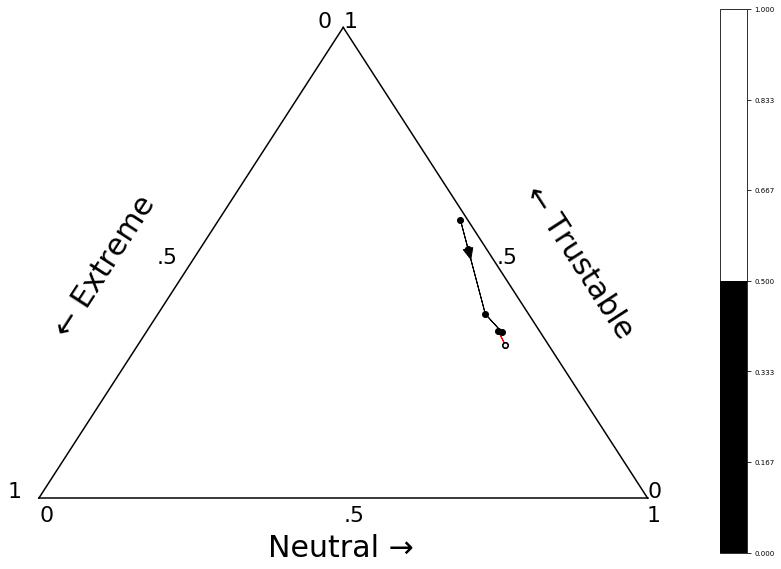

In [29]:
## Getting ternary plot with colormap
# Figure 3b: classification proportions shifts
import matplotlib.cm as cm

from matplotlib import colors
cmap = colors.ListedColormap(['black','white'])
bounds=[0, 1.0]
norm = colors.BoundaryNorm(bounds, cmap.N)

def classification(p):
    return round((p[2]-p[1]),2)

def classification2(p):
    if p[2]==1:
        return 0
    else:
        return 1

# Triangle setting 
pscale=10

scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 
figure, tax = ternary.figure(scale=pscale)
figure.set_size_inches(15, 10)
tax.boundary()
#tax.gridlines(multiple=0.125, color="lightgray", alpha=0.6, linestyle=':')

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)
#tax.set_title("Categories proportion over video sequence", fontsize=fontsizeL)

tax.heatmapf(classification2, boundary=True, style="triangular", cmap=cmap)
p0 = (0,0,0)

factor = 1
i=0
scaledpts = []
dis3 = []
plotbool = 1
for p in points:
    p1 = (p[0]*pscale,p[1]*pscale,p[2]*pscale)
    scaledpts.append(p1)
    pp1 = project_point(p1)
    if plotbool:
        plt.plot(pp1[0], pp1[1], marker='o', markersize=6, color='black')
    
    if p0 != (0,0,0):
        pp0 = project_point(p0)
        d3 = eucliDistance3(p00, p)
        dis3.append(d3)
        #print(d3)
        if p == points[1] or p == points[-1] :
            factor = 1
            i += 1
        else:
            factor = 0
            if p == points[int(len(points)/2)]:
                plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color='black')
                plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
        if p == points[int(len(points)/2)]:
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor*pscale, head_length=0.02*factor*pscale,  fc='black', ec='red')
            plotbool = 0
        elif plotbool:
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor*pscale, head_length=0.02*factor*pscale,  fc='black', ec='black')
    p00 = p    
    p0 = p1
    
plt.axis('off')

# Plot initial and final guide lines    
# P (neutral, trustable, extreme)



# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()

pp1 = project_point(pu)
plt.text(pp1[0]-(pscale*off3), pp1[1], str(round(mine,1)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str(int(mint+scale)), fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4*pscale), pp1[1]+off1, str(int(mine+scale)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3*pscale, str(int(minn)), fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str(round(mint,1)), fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3*pscale, str(int(minn+scale)), fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4*pscale + off3), pp1[1], str("{:.1f}".format(round((mine+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3*pscale, str("{:.1f}".format(round((minn+scale)/2,1)))[1:], fontsize=fontsize1)

tax._redraw_labels()
#tax.scatter(scaledpts, s=(1000)) 

output =  "figures/fig007d" + filesufix2 + "_overallClassMapTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

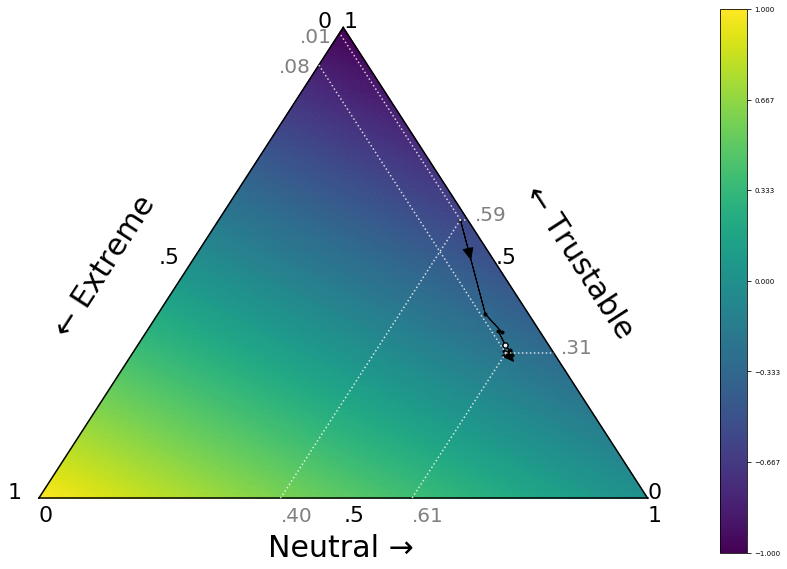

In [30]:
## Getting ternary plot with colormap
# Figure 3b: classification proportions shifts

def classification(p):
    return round((p[2]-p[1]),2)

# Triangle setting 
pscale=100

scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 
figure, tax = ternary.figure(scale=pscale)
figure.set_size_inches(15, 10)
tax.boundary()
#tax.gridlines(multiple=0.125, color="lightgray", alpha=0.6, linestyle=':')

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)
#tax.set_title("Categories proportion over video sequence", fontsize=fontsizeL)

tax.heatmapf(classification, boundary=True, style="triangular")
p0 = (0,0,0)

factor = 1
i=0
scaledpts = []
dis3 = []
for p in points:
    p1 = (p[0]*pscale,p[1]*pscale,p[2]*pscale)
    scaledpts.append(p1)
    pp1 = project_point(p1)
    plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color='black')
    
    if p0 != (0,0,0):
        pp0 = project_point(p0)
        d3 = eucliDistance3(p00, p)
        dis3.append(d3)
        #print(d3)
        if p == points[1] or p == points[-1] :
            factor = 1
            i += 1
        else:
            factor = 0
            if p == points[int(len(points)/2)]:
                plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color='black')
                plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
        plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor*pscale, head_length=0.02*factor*pscale,  fc='black', ec='black')
    p00 = p    
    p0 = p1
    
plt.axis('off')

# Plot initial and final guide lines    
# P (neutral, trustable, extreme)

# Guide to initial point
p0 = scaledpts[0]
pa0 = points[0]
pp0 = project_point(p0)
#print(pp0)

# extreme
x = (p0[2])/2
y = (p0[2])*math.sqrt(3)/2
pp1 = project_point((0, pscale,0))
plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='white', linestyle=':', alpha=.8)
plt.text((pp1[0]-x-off4*pscale-off2*pscale), (pp1[1]-(y+1.6)), str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

# trustable
x = (pscale-p0[1])/2
y = (pscale-p0[1])*math.sqrt(3)/2
pp1 = project_point((0,pscale,0))
plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='white', linestyle=':', alpha=.8)
plt.text(pp1[0]+x+off1*pscale, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

# neutral
x = (p0[0])
pp1 = project_point((0,0,pscale))
#print(pp1)
plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='white', linestyle=':', alpha=.8)
plt.text(pp1[0]+x, pp1[1]-off3*pscale, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

# Guide to final point
p0 = scaledpts[-1]
pa0 = points[-1]
pp0 = project_point(p0)
#print(pp0)

# extreme
x = (p0[2])/2
y = (p0[2])*math.sqrt(3)/2
pp1 = project_point((0, pscale,0))
#print(pp1)
plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='white', linestyle=':', alpha=.8)
plt.text(pp1[0]-x-off4*pscale-off2*pscale, (pp1[1]-y*1.2), str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

# trustable
x = (pscale-p0[1])/2
y = (pscale-p0[1])*math.sqrt(3)/2
pp1 = project_point((0,pscale,0))
#print(pp1)
plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='white', linestyle=':', alpha=.8)
plt.text(pp1[0]+x+off1*pscale, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

# neutral
x = (p0[0])
pp1 = project_point((0,0,pscale))
#print(pp1)
plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='white', linestyle=':', alpha=.8)
plt.text(pp1[0]+x, pp1[1]-off3*pscale, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)


# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()

pp1 = project_point(pu)
plt.text(pp1[0]-(pscale*off3), pp1[1], str(round(mine,1)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str(int(mint+scale)), fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4*pscale), pp1[1]+off1, str(int(mine+scale)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3*pscale, str(int(minn)), fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str(round(mint,1)), fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3*pscale, str(int(minn+scale)), fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4*pscale + off3), pp1[1], str("{:.1f}".format(round((mine+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3*pscale, str("{:.1f}".format(round((minn+scale)/2,1)))[1:], fontsize=fontsize1)

tax._redraw_labels()
#tax.scatter(scaledpts, s=(1000)) 

output =  "figures/fig007" + filesufix2 + "_overallClassMapTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

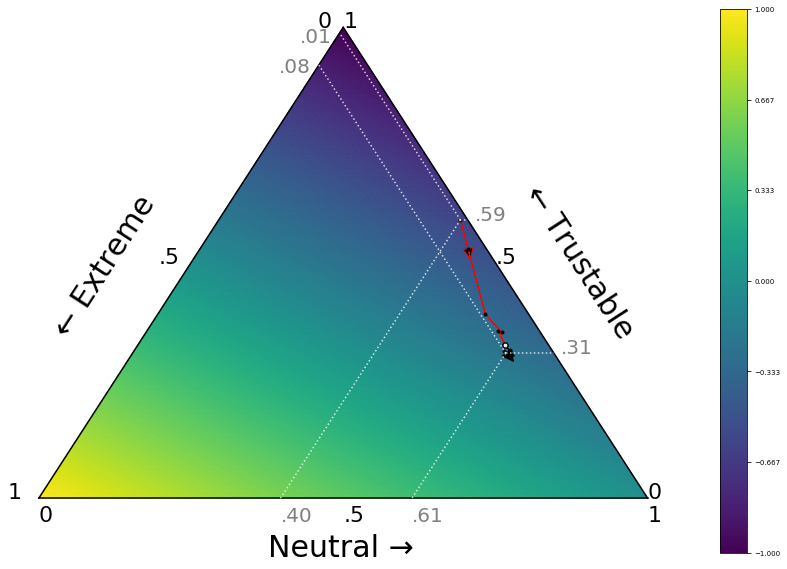

In [31]:
## Getting ternary plot with colormap
# Figure 3b: classification proportions shifts

def classification(p):
    return round((p[2]-p[1]),2)

# Triangle setting 
pscale=100

scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 
figure, tax = ternary.figure(scale=pscale)
figure.set_size_inches(15, 10)
tax.boundary()
#tax.gridlines(multiple=0.125, color="lightgray", alpha=0.6, linestyle=':')

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)
#tax.set_title("Categories proportion over video sequence", fontsize=fontsizeL)

tax.heatmapf(classification, boundary=True, style="triangular")
p0 = (0,0,0)

factor = 1
i=0
scaledpts = []
dis3 = []
plotbool = 1
for p in points:
    p1 = (p[0]*pscale,p[1]*pscale,p[2]*pscale)
    scaledpts.append(p1)
    pp1 = project_point(p1)
    plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color='black')
    
    if p0 != (0,0,0):
        pp0 = project_point(p0)
        d3 = eucliDistance3(p00, p)
        dis3.append(d3)
        #print(d3)
        if p == points[1] or p == points[-1] :
            factor = 1
            i += 1
        else:
            factor = 0
            if p == points[int(len(points)/2)]:
                plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color='black')
                plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
        if plotbool:
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor*pscale, head_length=0.02*factor*pscale,  fc='black', ec='red')
            if p == points[int(len(points)/2)]:
                plotbool = 0
        else:
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor*pscale, head_length=0.02*factor*pscale,  fc='black', ec='black')

    p00 = p    
    p0 = p1
    
plt.axis('off')

# Plot initial and final guide lines    
# P (neutral, trustable, extreme)

# Guide to initial point
p0 = scaledpts[0]
pa0 = points[0]
pp0 = project_point(p0)
#print(pp0)

# extreme
x = (p0[2])/2
y = (p0[2])*math.sqrt(3)/2
pp1 = project_point((0, pscale,0))
plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='white', linestyle=':', alpha=.8)
plt.text((pp1[0]-x-off4*pscale-off2*pscale), (pp1[1]-(y+1.6)), str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

# trustable
x = (pscale-p0[1])/2
y = (pscale-p0[1])*math.sqrt(3)/2
pp1 = project_point((0,pscale,0))
plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='white', linestyle=':', alpha=.8)
plt.text(pp1[0]+x+off1*pscale, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

# neutral
x = (p0[0])
pp1 = project_point((0,0,pscale))
#print(pp1)
plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='white', linestyle=':', alpha=.8)
plt.text(pp1[0]+x, pp1[1]-off3*pscale, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

# Guide to final point
p0 = scaledpts[-1]
pa0 = points[-1]
pp0 = project_point(p0)
#print(pp0)

# extreme
x = (p0[2])/2
y = (p0[2])*math.sqrt(3)/2
pp1 = project_point((0, pscale,0))
#print(pp1)
plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='white', linestyle=':', alpha=.8)
plt.text(pp1[0]-x-off4*pscale-off2*pscale, (pp1[1]-y*1.2), str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

# trustable
x = (pscale-p0[1])/2
y = (pscale-p0[1])*math.sqrt(3)/2
pp1 = project_point((0,pscale,0))
#print(pp1)
plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='white', linestyle=':', alpha=.8)
plt.text(pp1[0]+x+off1*pscale, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

# neutral
x = (p0[0])
pp1 = project_point((0,0,pscale))
#print(pp1)
plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='white', linestyle=':', alpha=.8)
plt.text(pp1[0]+x, pp1[1]-off3*pscale, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)


# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()

pp1 = project_point(pu)
plt.text(pp1[0]-(pscale*off3), pp1[1], str(round(mine,1)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str(int(mint+scale)), fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4*pscale), pp1[1]+off1, str(int(mine+scale)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3*pscale, str(int(minn)), fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str(round(mint,1)), fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3*pscale, str(int(minn+scale)), fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4*pscale + off3), pp1[1], str("{:.1f}".format(round((mine+scale)/2,1)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3*pscale, str("{:.1f}".format(round((minn+scale)/2,1)))[1:], fontsize=fontsize1)

tax._redraw_labels()
#tax.scatter(scaledpts, s=(1000)) 

output =  "figures/fig007h" + filesufix2 + "_overallClassMapTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()

In [32]:
# Cropped Triangle settings (for tenary plots)
scale = 0.67
mine = 0
mint = 0.15
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)
print(str(mine) + " " + str(maxe) + " " + str(maxe-mine))
print(str(mint) + " " + str(maxt) + " " + str(maxt-mint))
print(str(minn) + " " + str(maxn) + " " + str(maxn-minn))

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1, 0)
pl = (0, 0, 1)
pr = (1, 0, 0)
pmr = (0.5, 0.5, 0)
pmb = (0.5, 0, 0.5)
pml = (0, 0.5, 0.5)

# Fonts and text offset
fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.01
off2 = 0.012
off3 = 0.048
off4 = 0.054
off8 = off4*2+3*off2

0 0.67 0.67
0.15 0.8200000000000001 0.67
0.17999999999999994 0.85 0.67


In [33]:
## 
# Analysis per scenarios of privacy
##

tmp0 = dataSeqAvg.groupby(['setting']).mean().unstack()
tmp0 = pd.DataFrame(tmp0)
tmp0.reset_index(inplace=True) 
tmp0.columns = ['lab', 'bin', 'setting', 'mean']

tmp1 = dataSeqAvg.groupby(['setting']).std().unstack()
tmp1 = pd.DataFrame(tmp1)
tmp1.reset_index(inplace=True) 
tmp1.columns = ['lab','bin','setting', 'std']

seqSettings = pd.merge(tmp0, tmp1, on=['lab','bin','setting'], how='inner')
seqSettings['bin'] = np.where((seqSettings['bin']==0), 0 , seqSettings['bin']*BINSIZE )

tmp2 = dataSeqAvg.groupby(['setting']).size()
tmp2 = pd.DataFrame(tmp2)
tmp2.reset_index(inplace=True) 
tmp2.columns = ['setting', 'size']
seqSettings = pd.merge(seqSettings, tmp2, on=['setting'], how='left')

seqSettings['sem'] = seqSettings.apply(lambda x: auxSem(x['std'], x['size']), axis=1)
seqSettings['sem'] = np.where((seqSettings['bin']==0), seqSettings['sem']*math.sqrt(BINSIZE), seqSettings['sem'])


/Users/larissapspinelli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


logged (ternary points):
[(0.332, 0.656, 0.012), (0.332, 0.643, 0.025), (0.316, 0.646, 0.037), (0.379, 0.592, 0.029), (0.393, 0.572, 0.035), (0.424, 0.539, 0.037), (0.426, 0.531, 0.043), (0.43, 0.539, 0.031), (0.422, 0.537, 0.041), (0.422, 0.535, 0.043), (0.424, 0.525, 0.051)]
normal (ternary points):
[(0.383, 0.609, 0.008), (0.441, 0.531, 0.027), (0.596, 0.334, 0.07), (0.674, 0.268, 0.059), (0.645, 0.271, 0.084), (0.67, 0.256, 0.074), (0.693, 0.246, 0.061), (0.674, 0.256, 0.07), (0.721, 0.219, 0.061), (0.693, 0.223, 0.084), (0.68, 0.236, 0.084)]
private (ternary points):
[(0.406, 0.59, 0.004), (0.469, 0.504, 0.027), (0.631, 0.279, 0.09), (0.674, 0.232, 0.094), (0.672, 0.238, 0.09), (0.67, 0.23, 0.1), (0.686, 0.221, 0.094), (0.699, 0.203, 0.098), (0.689, 0.209, 0.102), (0.662, 0.23, 0.107), (0.711, 0.197, 0.092)]
tor (ternary points):


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

[(0.469, 0.508, 0.023), (0.52, 0.441, 0.039), (0.607, 0.305, 0.088), (0.615, 0.314, 0.07), (0.604, 0.336, 0.061), (0.65, 0.273, 0.076), (0.666, 0.252, 0.082), (0.666, 0.26, 0.074), (0.666, 0.256, 0.078), (0.656, 0.262, 0.082), (0.637, 0.271, 0.092)]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


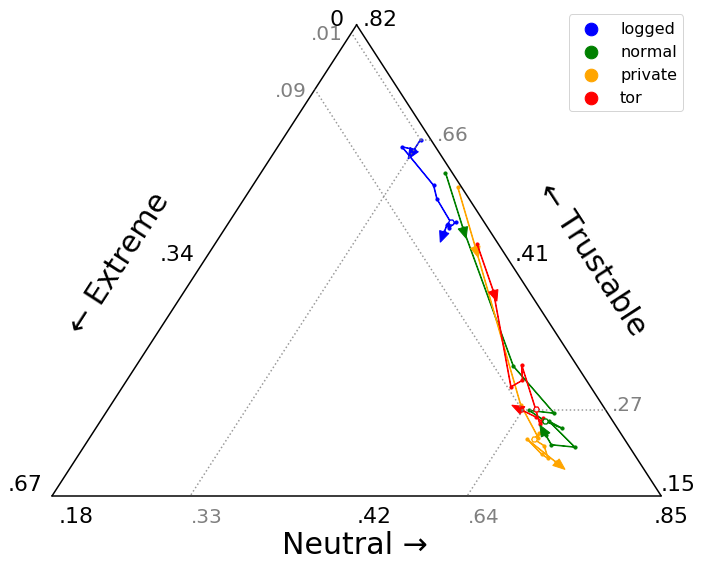

In [34]:
# Ternary plot: Information Sources on Sequences of Recommendation per Privacy Scenarios
# Figure 4a - classification proportion shifts

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

dis003 = []
dis002 = []
my_dic = {}
for key, group in seqSettings.groupby('setting'):
    print(str(key) + " (ternary points):")
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=0
    dis03 = []
    dis02 = []
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            if p == pointsS[1] or p == pointsS[-1] :
                factor = 1
            
            
            else:
                factor = 0
                if p == pointsS[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color=colorMap[key])
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key])
            d3 = eucliDistance3(p0, p)
            d2 = eucliDistance2(pp0, pp1)
            #print(str(key) + " " + str(i) + " distance " + str(d2))
            i += 1
            dis03.append(d3)
            dis02.append(d2)
        p0 = p
    
    my_dic[key] = dis03
    dis003.append(dis03)
    dis002.append(dis02)

        
    if key == 'logged' : 
        # Plot initial and final guide lines    
        # P (neutral, trustable, extreme)

        # Guide to initial point
        p0 = pointsS[0]
        pa0 = points0S[0]
        pp0 = project_point(p0)

        # extreme
        x = (p0[2])/2
        y = (p0[2])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

    if key == 'tor': 
        # Guide to final point   
        p0 = pointsS[-1]
        pa0 = points0S[-1]
        pp0 = project_point(p0)

        # extreme
        x = p0[2]/2
        y = p0[2]*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007" + filesufix2 + "_settingTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

logged (ternary points)
[(0.332, 0.656, 0.012), (0.424, 0.539, 0.037), (0.424, 0.525, 0.051)]
normal (ternary points)
[(0.383, 0.609, 0.008), (0.67, 0.256, 0.074), (0.68, 0.236, 0.084)]
private (ternary points)
[(0.406, 0.59, 0.004), (0.67, 0.23, 0.1), (0.711, 0.197, 0.092)]
tor (ternary points)
[(0.469, 0.508, 0.023), (0.65, 0.273, 0.076), (0.637, 0.271, 0.092)]
Point 0 distance log-nor 0.07318469785412793
Point 0 distance nor-pri 0.032787192621510024
Point 0 distance pri-tor 0.11039474625180307
Point 1 distance log-nor 0.39796607895648595
Point 1 distance nor-pri 0.03800000000000001
Point 1 distance pri-tor 0.05550675634551167
Point 2 distance log-nor 0.4087089428921271
Point 2 distance nor-pri 0.05302829433425142
Point 2 distance pri-tor 0.10999999999999996


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

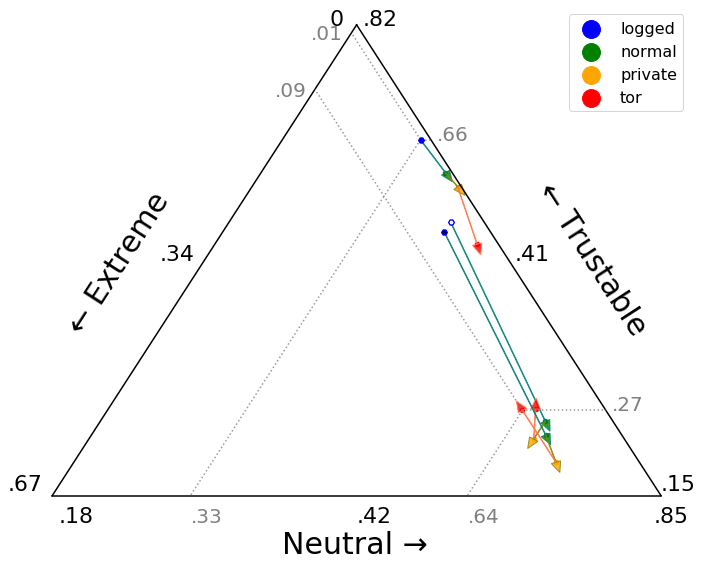

In [35]:
# Ternary plot: Information Sources on Sequences of Recommendation per Privacy Scenarios
# Figure 4b - Progression path of increses in privacy (logged -> normal -> private -> tor)
# in time (initial, middle and end observation)


# Ternary plot 
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

setPoint = []
for key, group in seqSettings.groupby('setting'):
    print(str(key) + " (ternary points)") 
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        if b == 0 or b == 10 or b == 20:
            p0t = tmp0t[tmp0t['bin']== b]
            p0n = tmp0n[tmp0n['bin']== b]
            p0e = tmp0e[tmp0e['bin']== b]
            pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
            points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))

    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=20)
    setPoint.append(pointsS)
    
    if key == 'logged' :    
        # Plot initial and final guide lines    
        # P (neutral, trustable, extreme)

        # Guide to initial point
        p0 = pointsS[0]
        pa0 = points0S[0]
        pp0 = project_point(p0)


        # extreme
        x = (p0[2])/2
        y = (p0[2])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)
    
    if key == 'tor':
        # Guide to final point   
        p0 = pointsS[-1]
        pa0 = points0S[-1]
        pp0 = project_point(p0)

        # extreme
        x = p0[2]/2
        y = p0[2]*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)


i = 0
for f in range(len(setPoint[0])):    
    pp0 = project_point(setPoint[0][f])
    pp1 = project_point(setPoint[1][f])
    pp2 = project_point(setPoint[2][f])
    pp3 = project_point(setPoint[3][f])
  
    plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016, head_length=0.02, fc=colorMap['normal'], ec='teal', alpha=0.8)
    print("Point " + str(f) + " distance log-nor " + str(eucliDistance2(pp0, pp1)))
    plt.arrow(pp1[0], pp1[1], pp2[0]-pp1[0], pp2[1]-pp1[1], head_width=0.016, head_length=0.02, fc=colorMap['private'], ec='olive', alpha=0.8)
    print("Point " + str(f) + " distance nor-pri " + str(eucliDistance2(pp2, pp1)))
    plt.arrow(pp2[0], pp2[1], pp3[0]-pp2[0], pp3[1]-pp2[1], head_width=0.016, head_length=0.02, fc=colorMap['tor'], ec='coral', alpha=0.8)
    print("Point " + str(f) + " distance pri-tor " + str(eucliDistance2(pp2, pp3)))
    if f == 0:
        plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['logged'])
    elif f == int(len(setPoint[0])/2):
        plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['logged'])    
        plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='white')
    elif f == (len(setPoint[0])-1):
        plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['logged'])    
        plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='black')
   
    

# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)



# Plotting and saving
output =  "figures/fig007"+ filesufix2 + "_settingDifTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

logged (ternary points)
[(0.332, 0.656, 0.012)]
normal (ternary points)
[(0.383, 0.609, 0.008)]
private (ternary points)
[(0.406, 0.59, 0.004)]
tor (ternary points)
[(0.469, 0.508, 0.023)]
Point 0 distance log-nor 0.07318469785412793
Point 0 distance nor-pri 0.032787192621510024
Point 0 distance pri-tor 0.11039474625180307


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

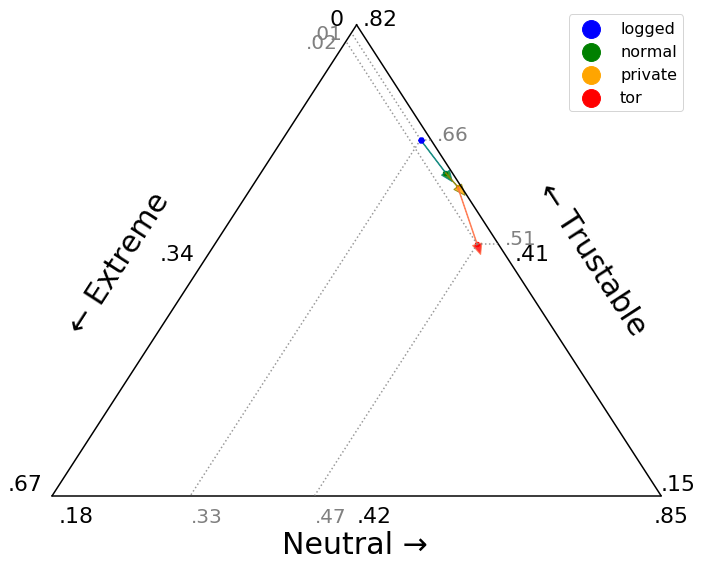

In [36]:
# Ternary plot: Information Sources on Sequences of Recommendation per Privacy Scenarios
# Figure 4b - Progression path of increses in privacy (logged -> normal -> private -> tor)
# in time (initial, middle and end observation)


# Ternary plot 
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

setPoint = []
for key, group in seqSettings.groupby('setting'):
    print(str(key) + " (ternary points)") 
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        if b == 0 :
            p0t = tmp0t[tmp0t['bin']== b]
            p0n = tmp0n[tmp0n['bin']== b]
            p0e = tmp0e[tmp0e['bin']== b]
            pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
            points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))

    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=20)
    setPoint.append(pointsS)
    
    if key == 'logged' :    
        # Plot initial and final guide lines    
        # P (neutral, trustable, extreme)

        # Guide to initial point
        p0 = pointsS[0]
        pa0 = points0S[0]
        pp0 = project_point(p0)


        # extreme
        x = (p0[2])/2
        y = (p0[2])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)
    
    if key == 'tor':
        # Guide to final point   
        p0 = pointsS[-1]
        pa0 = points0S[-1]
        pp0 = project_point(p0)

        # extreme
        x = p0[2]/2
        y = p0[2]*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)


i = 0
for f in range(len(setPoint[0])):    
    pp0 = project_point(setPoint[0][f])
    pp1 = project_point(setPoint[1][f])
    pp2 = project_point(setPoint[2][f])
    pp3 = project_point(setPoint[3][f])
  
    plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016, head_length=0.02, fc=colorMap['normal'], ec='teal', alpha=0.8)
    print("Point " + str(f) + " distance log-nor " + str(eucliDistance2(pp0, pp1)))
    plt.arrow(pp1[0], pp1[1], pp2[0]-pp1[0], pp2[1]-pp1[1], head_width=0.016, head_length=0.02, fc=colorMap['private'], ec='olive', alpha=0.8)
    print("Point " + str(f) + " distance nor-pri " + str(eucliDistance2(pp2, pp1)))
    plt.arrow(pp2[0], pp2[1], pp3[0]-pp2[0], pp3[1]-pp2[1], head_width=0.016, head_length=0.02, fc=colorMap['tor'], ec='coral', alpha=0.8)
    print("Point " + str(f) + " distance pri-tor " + str(eucliDistance2(pp2, pp3)))
    if f == 0:
        plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['logged'])
    elif f == int(len(setPoint[0])/2):
        plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['logged'])    
        plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='white')
    elif f == (len(setPoint[0])-1):
        plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['logged'])    
        plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='black')
   
    

# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)



# Plotting and saving
output =  "figures/fig007a"+ filesufix2 + "_settingDifTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

logged (ternary points)
[(0.332, 0.656, 0.012), (0.424, 0.539, 0.037)]
normal (ternary points)
[(0.383, 0.609, 0.008), (0.67, 0.256, 0.074)]
private (ternary points)
[(0.406, 0.59, 0.004), (0.67, 0.23, 0.1)]
tor (ternary points)
[(0.469, 0.508, 0.023), (0.65, 0.273, 0.076)]
Point 0 distance log-nor 0.07318469785412793
Point 0 distance nor-pri 0.032787192621510024
Point 0 distance pri-tor 0.11039474625180307
Point 1 distance log-nor 0.39796607895648595
Point 1 distance nor-pri 0.03800000000000001
Point 1 distance pri-tor 0.05550675634551167


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

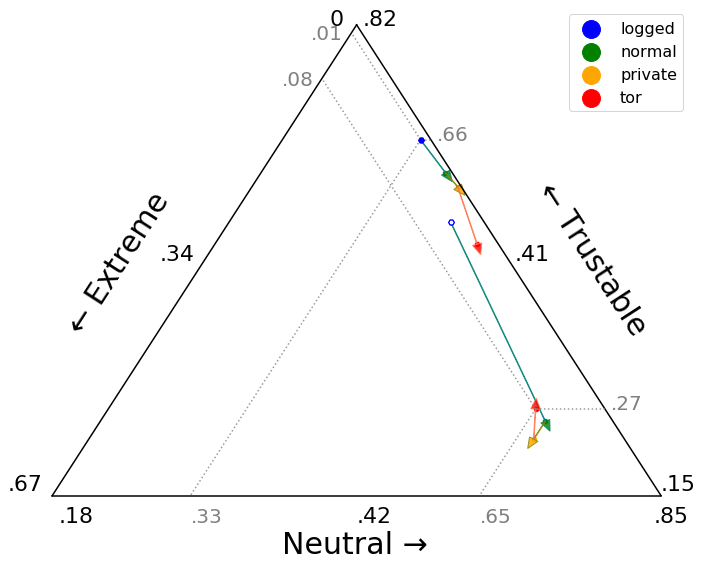

In [37]:
# Ternary plot: Information Sources on Sequences of Recommendation per Privacy Scenarios
# Figure 4b - Progression path of increses in privacy (logged -> normal -> private -> tor)
# in time (initial, middle and end observation)


# Ternary plot 
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

setPoint = []
for key, group in seqSettings.groupby('setting'):
    print(str(key) + " (ternary points)") 
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        if b == 0 or b == 10:
            p0t = tmp0t[tmp0t['bin']== b]
            p0n = tmp0n[tmp0n['bin']== b]
            p0e = tmp0e[tmp0e['bin']== b]
            pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
            points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))

    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=20)
    setPoint.append(pointsS)
    
    if key == 'logged' :    
        # Plot initial and final guide lines    
        # P (neutral, trustable, extreme)

        # Guide to initial point
        p0 = pointsS[0]
        pa0 = points0S[0]
        pp0 = project_point(p0)


        # extreme
        x = (p0[2])/2
        y = (p0[2])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)
    
    if key == 'tor':
        # Guide to final point   
        p0 = pointsS[-1]
        pa0 = points0S[-1]
        pp0 = project_point(p0)

        # extreme
        x = p0[2]/2
        y = p0[2]*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)


i = 0
for f in range(len(setPoint[0])):    
    pp0 = project_point(setPoint[0][f])
    pp1 = project_point(setPoint[1][f])
    pp2 = project_point(setPoint[2][f])
    pp3 = project_point(setPoint[3][f])
  
    plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016, head_length=0.02, fc=colorMap['normal'], ec='teal', alpha=0.8)
    print("Point " + str(f) + " distance log-nor " + str(eucliDistance2(pp0, pp1)))
    plt.arrow(pp1[0], pp1[1], pp2[0]-pp1[0], pp2[1]-pp1[1], head_width=0.016, head_length=0.02, fc=colorMap['private'], ec='olive', alpha=0.8)
    print("Point " + str(f) + " distance nor-pri " + str(eucliDistance2(pp2, pp1)))
    plt.arrow(pp2[0], pp2[1], pp3[0]-pp2[0], pp3[1]-pp2[1], head_width=0.016, head_length=0.02, fc=colorMap['tor'], ec='coral', alpha=0.8)
    print("Point " + str(f) + " distance pri-tor " + str(eucliDistance2(pp2, pp3)))
    if f == 0:
        plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['logged'])
    elif f == int(len(setPoint[0])/2):
        plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['logged'])    
        plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='white')
    elif f == (len(setPoint[0])-1):
        plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['logged'])    
        plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='black')
   
    

# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)



# Plotting and saving
output =  "figures/fig007b"+ filesufix2 + "_settingDifTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()





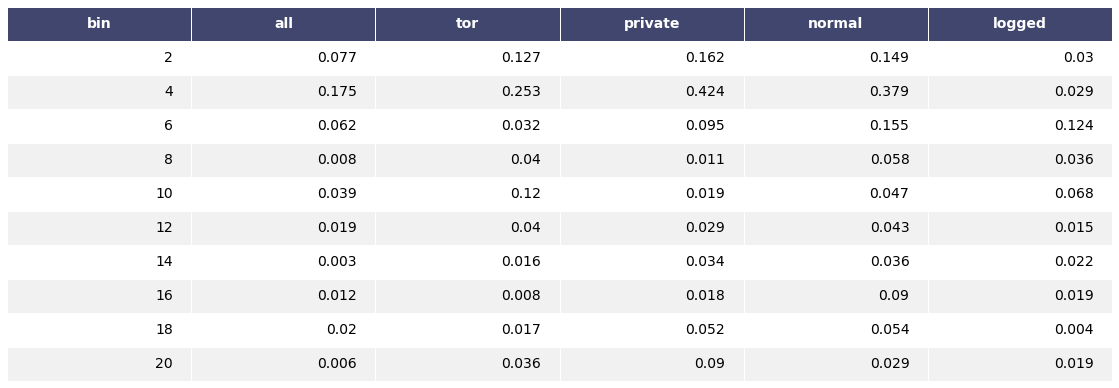

In [38]:
# Observing rate of change per privacy scenarios
# Euclidean distance between observation points 
my_dic['all'] = dis3
tabSet = pd.DataFrame(my_dic)

for col in tabSet.columns:
    tabSet[col] = round(tabSet[col], 3)
    
tabSet['bin'] = tabSet.index
tabSet['bin'] = np.where((tabSet['bin']==0), 2 ,tabSet['bin']*BINSIZE+2 )
tabSet['bin'] = tabSet.apply(lambda x: str(int(x['bin'])), axis=1)
                         
tabSet = tabSet[['bin', 'all', 'tor', 'private', 'normal', 'logged']]

render_mpl_table(tabSet, header_columns=0, col_width=3.3)
fig = plt.gcf()
fig.savefig("figures/fig007" + filesufix2 + "_tableEucDis.eps", format='eps', bbox_inches='tight', pad_inches=0.01)

all
tor
private
normal
logged


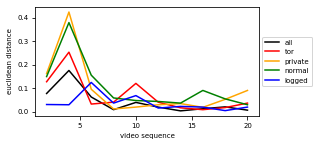

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [39]:
# Figure 5: 
# Plotting rate of change per privacy scenarios

data0 = tabSet.copy()
data0 = pd.DataFrame(data0)

data0['bin'] = data0['bin'].astype(int)

fig, ax = plt.subplots(figsize=(4,2))    # 1
ax.locator_params(integer=True)
plt.rc('font', size=7)
   
for col in  data0.columns:
    if col != 'bin':
        print(col)
        data0.plot('bin', col, legend=col, ax=ax, color=colorMap[col])
        
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(1, 21)

plt.rc('font', size=7) 
plt.xlabel('video sequence')
plt.ylabel('euclidean distance')
fig = plt.gcf()
   
plt.show()
fig.savefig("figures/fig007" + filesufix2 + "_plotEucDis.eps", format='eps', bbox_inches='tight', pad_inches=0.01)    

In [40]:
###
# Analysis by search query
###

tmp0 = dataSeqAvg.groupby(['search']).mean().unstack()
tmp0 = pd.DataFrame(tmp0)
tmp0.reset_index(inplace=True) 
tmp0.columns = ['lab', 'bin', 'search', 'mean']

tmp1 = dataSeqAvg.groupby(['search']).std().unstack()
tmp1 = pd.DataFrame(tmp1)
tmp1.reset_index(inplace=True) 
tmp1.columns = ['lab','bin','search', 'std']

datQue = pd.merge(tmp0, tmp1, on=['lab','bin','search'], how='inner')
datQue['bin'] = np.where((datQue['bin']==0), 0 , datQue['bin']*BINSIZE )


tmp2 = dataSeqAvg.groupby(['search']).size()
tmp2 = pd.DataFrame(tmp2)
tmp2.reset_index(inplace=True) 
tmp2.columns = ['search', 'size']
datQue = pd.merge(datQue, tmp2, on=['search'], how='left')


datQue['sem'] = datQue.apply(lambda x: auxSem(x['std'], x['size']), axis=1)



April the Giraffe
[(1.0, 0.0, 0.0), (0.949, 0.044, 0.007), (0.765, 0.162, 0.074), (0.912, 0.074, 0.015), (0.868, 0.118, 0.015), (0.831, 0.14, 0.029), (0.868, 0.125, 0.007), (0.853, 0.132, 0.015), (0.86, 0.118, 0.022), (0.846, 0.14, 0.015), (0.868, 0.132, 0.0)]
April the Giraffe begin-end distance 0.13200000000000003
Bitcoin Price
[(0.962, 0.012, 0.025), (0.844, 0.05, 0.106), (0.606, 0.238, 0.156), (0.519, 0.288, 0.194), (0.481, 0.325, 0.194), (0.581, 0.281, 0.138), (0.631, 0.262, 0.106), (0.65, 0.269, 0.081), (0.55, 0.306, 0.144), (0.538, 0.325, 0.138), (0.556, 0.319, 0.125)]
Bitcoin Price begin-end distance 0.3666646969644064
DACA
[(0.083, 0.917, 0.0), (0.097, 0.903, 0.0), (0.111, 0.812, 0.076), (0.139, 0.812, 0.049), (0.181, 0.785, 0.035), (0.188, 0.771, 0.042), (0.174, 0.736, 0.09), (0.208, 0.729, 0.062), (0.208, 0.708, 0.083), (0.271, 0.681, 0.049), (0.264, 0.688, 0.049)]
DACA begin-end distance 0.20917217788224138
Hurricane Harvey
[(0.705, 0.295, 0.0), (0.682, 0.318, 0.0), (0.625,

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


North Korea begin-end distance 0.5285915247145001
Solar Eclipse
[(0.855, 0.145, 0.0), (0.862, 0.138, 0.0), (0.836, 0.164, 0.0), (0.862, 0.138, 0.0), (0.803, 0.197, 0.0), (0.816, 0.184, 0.0), (0.803, 0.197, 0.0), (0.809, 0.191, 0.0), (0.836, 0.164, 0.0), (0.809, 0.191, 0.0), (0.816, 0.184, 0.0)]
Solar Eclipse begin-end distance 0.039000000000000035


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


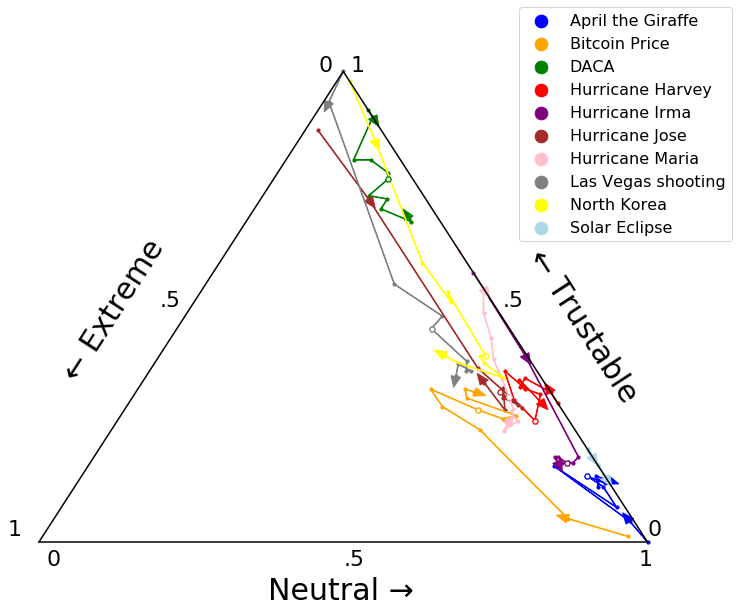

In [41]:
##
# Figure 8: Information Sources Shifts on Sequences of Recommendation per Search Query
##

# Triangle setting 
pscale=1
scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 

off8 = off4*2+2*off2

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("     \u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

dis003 = []
dis002 = []
my_dic = {}
for key, group in datQue.groupby('search'):
    print(key)
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=0
    dis03 = []
    dis02 = []
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            #print(pp0)
            #print(pp1)
            if p == pointsS[1] or p == pointsS[-1] :
                factor = 1
            
            
            else:
                factor = 0
                if p == pointsS[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color=colorMap[key])
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0]+0.000001, pp1[1]-pp0[1]+0.000001, head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key])
            d3 = eucliDistance3(p0, p)
            d2 = eucliDistance2(pp0, pp1)
            #print(str(key) + " " + str(i) + " distance " + str(d2))
            i += 1
            dis03.append(d3)
            dis02.append(d2)
        p0 = p
    
    my_dic[key] = dis03
    dis003.append(dis03)
    dis002.append(dis02)
    pp0 = project_point(pointsS[0])
    pp1 = project_point(pointsS[-1])
    d2 = eucliDistance2(pp0, pp1)
    print(str(key) + " begin-end distance " + str(d2))
    
        
   
# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16, loc='upper left', bbox_to_anchor=(0.75, 1.1), ncol=1)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], "0", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], "1", fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4), pp1[1]+off1, "1", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, "0", fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, "0", fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, "1", fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4), pp1[1], str("{:.1f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.1f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007" + filesufix2 + "_searchTernary3.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()



April the Giraffe
[(1.0, 0.0, 0.0), (0.949, 0.044, 0.007), (0.765, 0.162, 0.074), (0.912, 0.074, 0.015), (0.868, 0.118, 0.015), (0.831, 0.14, 0.029), (0.868, 0.125, 0.007), (0.853, 0.132, 0.015), (0.86, 0.118, 0.022), (0.846, 0.14, 0.015), (0.868, 0.132, 0.0)]
April the Giraffe begin-end distance 0.13200000000000003


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


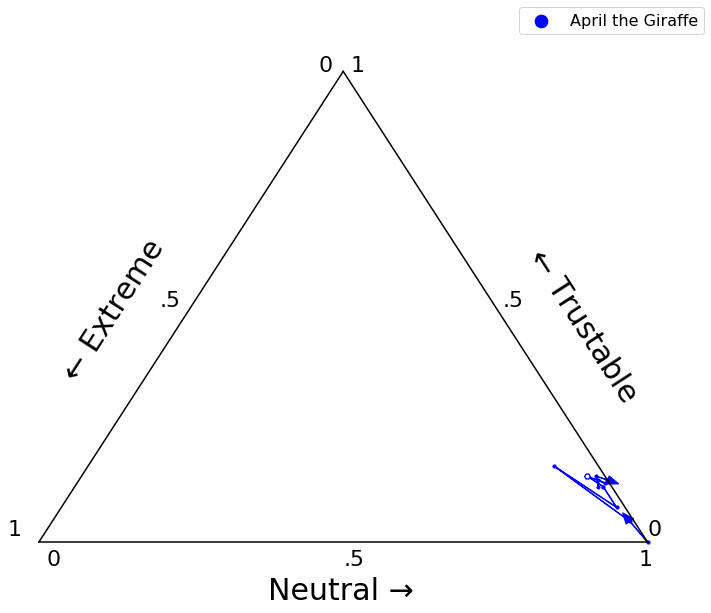

In [42]:
##
# Figure 8: Information Sources Shifts on Sequences of Recommendation per Search Query
##

# Triangle setting 
pscale=1
scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 

off8 = off4*2+2*off2

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("     \u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

dis003 = []
dis002 = []
my_dic = {}
datQue = datQue[datQue['search'] == 'April the Giraffe']
for key, group in datQue.groupby('search'):
    print(key)
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=0
    dis03 = []
    dis02 = []
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            #print(pp0)
            #print(pp1)
            if p == pointsS[1] or p == pointsS[-1] :
                factor = 1
            
            
            else:
                factor = 0
                if p == pointsS[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color=colorMap[key])
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0]+0.000001, pp1[1]-pp0[1]+0.000001, head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key])
            d3 = eucliDistance3(p0, p)
            d2 = eucliDistance2(pp0, pp1)
            #print(str(key) + " " + str(i) + " distance " + str(d2))
            i += 1
            dis03.append(d3)
            dis02.append(d2)
        p0 = p
    
    my_dic[key] = dis03
    dis003.append(dis03)
    dis002.append(dis02)
    pp0 = project_point(pointsS[0])
    pp1 = project_point(pointsS[-1])
    d2 = eucliDistance2(pp0, pp1)
    print(str(key) + " begin-end distance " + str(d2))
    
        
   
# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16, loc='upper left', bbox_to_anchor=(0.75, 1.1), ncol=1)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], "0", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], "1", fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4), pp1[1]+off1, "1", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, "0", fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, "0", fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, "1", fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4), pp1[1], str("{:.1f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.1f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007a" + filesufix2 + "_searchTernary3.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


April the Giraffe
[(1.0, 0.0, 0.0), (0.949, 0.044, 0.007), (0.765, 0.162, 0.074), (0.912, 0.074, 0.015), (0.868, 0.118, 0.015), (0.831, 0.14, 0.029), (0.868, 0.125, 0.007), (0.853, 0.132, 0.015), (0.86, 0.118, 0.022), (0.846, 0.14, 0.015), (0.868, 0.132, 0.0)]
April the Giraffe begin-end distance 0.13200000000000003


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


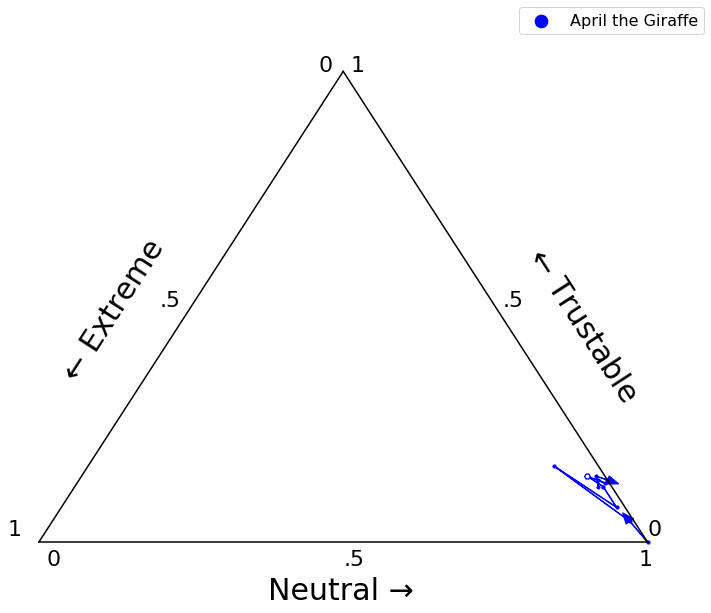

In [43]:
##
# Figure 8: Information Sources Shifts on Sequences of Recommendation per Search Query
##

# Triangle setting 
pscale=1
scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 

off8 = off4*2+2*off2

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("     \u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

dis003 = []
dis002 = []
my_dic = {}

datQue = datQue[(datQue.search == 'April the Giraffe') | (datQue.search == 'DACA')]
for key, group in datQue.groupby('search'):
    print(key)
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=0
    dis03 = []
    dis02 = []
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            #print(pp0)
            #print(pp1)
            if p == pointsS[1] or p == pointsS[-1] :
                factor = 1
            
            
            else:
                factor = 0
                if p == pointsS[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color=colorMap[key])
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0]+0.000001, pp1[1]-pp0[1]+0.000001, head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key])
            d3 = eucliDistance3(p0, p)
            d2 = eucliDistance2(pp0, pp1)
            #print(str(key) + " " + str(i) + " distance " + str(d2))
            i += 1
            dis03.append(d3)
            dis02.append(d2)
        p0 = p
    
    my_dic[key] = dis03
    dis003.append(dis03)
    dis002.append(dis02)
    pp0 = project_point(pointsS[0])
    pp1 = project_point(pointsS[-1])
    d2 = eucliDistance2(pp0, pp1)
    print(str(key) + " begin-end distance " + str(d2))
    
        
   
# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16, loc='upper left', bbox_to_anchor=(0.75, 1.1), ncol=1)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], "0", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], "1", fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4), pp1[1]+off1, "1", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, "0", fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, "0", fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, "1", fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4), pp1[1], str("{:.1f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.1f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007b" + filesufix2 + "_searchTernary3.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()





No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


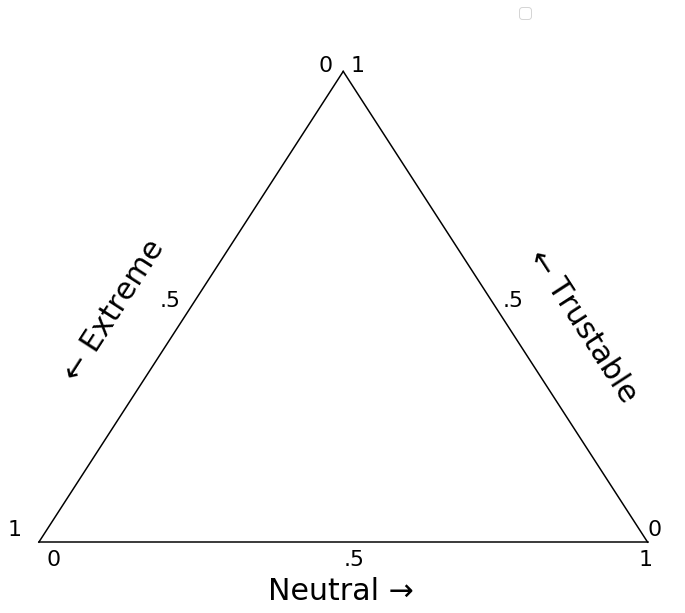

In [44]:
##
# Figure 8: Information Sources Shifts on Sequences of Recommendation per Search Query
##

# Triangle setting 
pscale=1
scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 

off8 = off4*2+2*off2

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("     \u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

dis003 = []
dis002 = []
my_dic = {}

datQue = datQue[(datQue.search == 'Las Vegas shooting') | (datQue.search == 'Hurricane Maria')| (datQue.search == 'Hurricane Irma')| (datQue.search == 'Bitcoin Price')]
for key, group in datQue.groupby('search'):
    print(key)
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=0
    dis03 = []
    dis02 = []
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            #print(pp0)
            #print(pp1)
            if p == pointsS[1] or p == pointsS[-1] :
                factor = 1
            
            
            else:
                factor = 0
                if p == pointsS[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color=colorMap[key])
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0]+0.000001, pp1[1]-pp0[1]+0.000001, head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key])
            d3 = eucliDistance3(p0, p)
            d2 = eucliDistance2(pp0, pp1)
            #print(str(key) + " " + str(i) + " distance " + str(d2))
            i += 1
            dis03.append(d3)
            dis02.append(d2)
        p0 = p
    
    my_dic[key] = dis03
    dis003.append(dis03)
    dis002.append(dis02)
    pp0 = project_point(pointsS[0])
    pp1 = project_point(pointsS[-1])
    d2 = eucliDistance2(pp0, pp1)
    print(str(key) + " begin-end distance " + str(d2))
    
        
   
# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16, loc='upper left', bbox_to_anchor=(0.75, 1.1), ncol=1)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], "0", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], "1", fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4), pp1[1]+off1, "1", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, "0", fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, "0", fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, "1", fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4), pp1[1], str("{:.1f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.1f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007c" + filesufix2 + "_searchTernary3.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()






No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


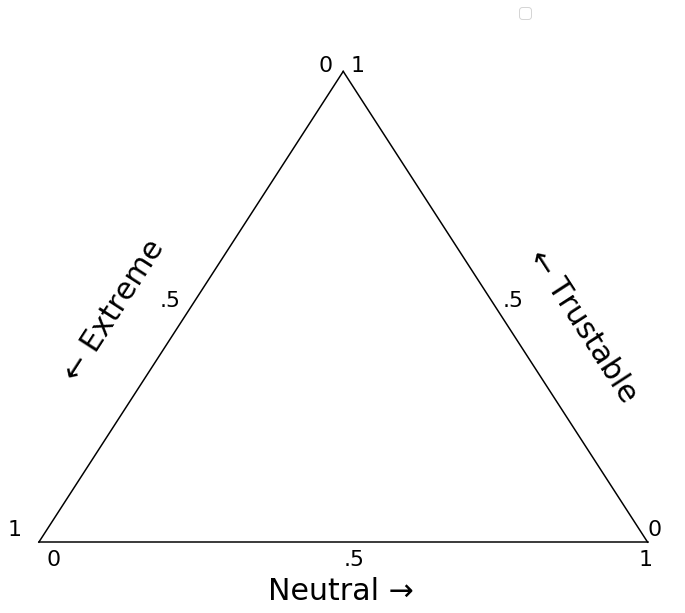

In [45]:
##
# Figure 8: Information Sources Shifts on Sequences of Recommendation per Search Query
##

# Triangle setting 
pscale=1
scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 

off8 = off4*2+2*off2

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("     \u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

dis003 = []
dis002 = []
my_dic = {}

datQue = datQue[(datQue.search == 'Las Vegas shooting') |  (datQue.search == 'Hurricane Irma')| (datQue.search == 'Bitcoin Price')]
for key, group in datQue.groupby('search'):
    print(key)
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=0
    dis03 = []
    dis02 = []
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            #print(pp0)
            #print(pp1)
            if p == pointsS[1] or p == pointsS[-1] :
                factor = 1
            
            
            else:
                factor = 0
                if p == pointsS[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color=colorMap[key])
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0]+0.000001, pp1[1]-pp0[1]+0.000001, head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key])
            d3 = eucliDistance3(p0, p)
            d2 = eucliDistance2(pp0, pp1)
            #print(str(key) + " " + str(i) + " distance " + str(d2))
            i += 1
            dis03.append(d3)
            dis02.append(d2)
        p0 = p
    
    my_dic[key] = dis03
    dis003.append(dis03)
    dis002.append(dis02)
    pp0 = project_point(pointsS[0])
    pp1 = project_point(pointsS[-1])
    d2 = eucliDistance2(pp0, pp1)
    print(str(key) + " begin-end distance " + str(d2))
    
        
   
# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16, loc='upper left', bbox_to_anchor=(0.75, 1.1), ncol=1)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], "0", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], "1", fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4), pp1[1]+off1, "1", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, "0", fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, "0", fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, "1", fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4), pp1[1], str("{:.1f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.1f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007d" + filesufix2 + "_searchTernary3.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()







No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


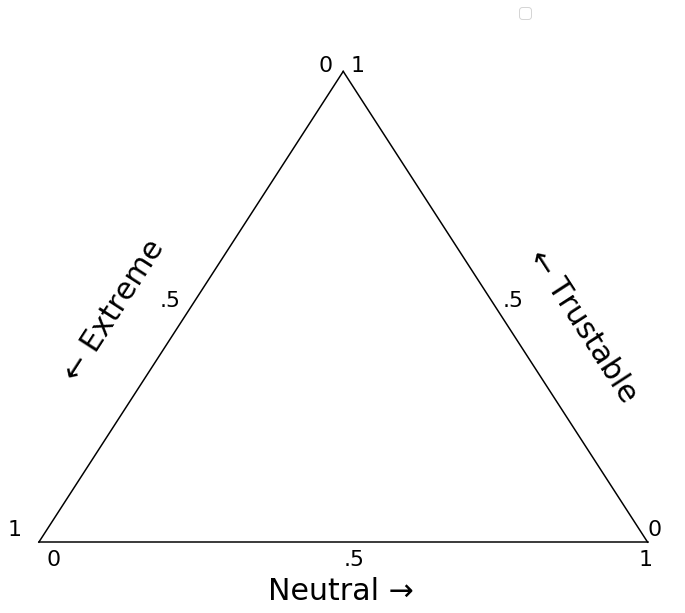

In [46]:
##
# Figure 8: Information Sources Shifts on Sequences of Recommendation per Search Query
##

# Triangle setting 
pscale=1
scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 

off8 = off4*2+2*off2

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("     \u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

dis003 = []
dis002 = []
my_dic = {}

datQue = datQue[(datQue.search == 'Las Vegas shooting') |  (datQue.search == 'Hurricane Irma')]
for key, group in datQue.groupby('search'):
    print(key)
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=0
    dis03 = []
    dis02 = []
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            #print(pp0)
            #print(pp1)
            if p == pointsS[1] or p == pointsS[-1] :
                factor = 1
            
            
            else:
                factor = 0
                if p == pointsS[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color=colorMap[key])
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0]+0.000001, pp1[1]-pp0[1]+0.000001, head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key])
            d3 = eucliDistance3(p0, p)
            d2 = eucliDistance2(pp0, pp1)
            #print(str(key) + " " + str(i) + " distance " + str(d2))
            i += 1
            dis03.append(d3)
            dis02.append(d2)
        p0 = p
    
    my_dic[key] = dis03
    dis003.append(dis03)
    dis002.append(dis02)
    pp0 = project_point(pointsS[0])
    pp1 = project_point(pointsS[-1])
    d2 = eucliDistance2(pp0, pp1)
    print(str(key) + " begin-end distance " + str(d2))
    
        
   
# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16, loc='upper left', bbox_to_anchor=(0.75, 1.1), ncol=1)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], "0", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], "1", fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4), pp1[1]+off1, "1", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, "0", fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, "0", fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, "1", fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4), pp1[1], str("{:.1f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.1f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007e" + filesufix2 + "_searchTernary3.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()








No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


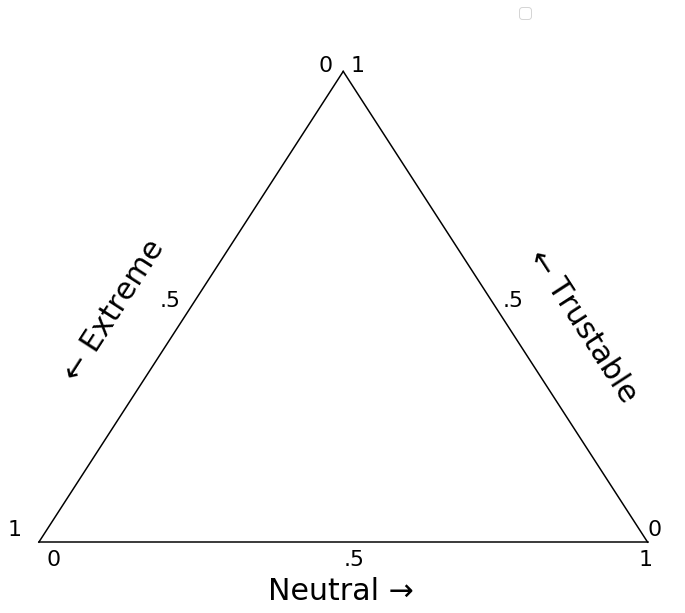

In [47]:
##
# Figure 8: Information Sources Shifts on Sequences of Recommendation per Search Query
##

# Triangle setting 
pscale=1
scale = 1.0
mine = 0
mint = 0
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1*pscale, 0)
pl = (0, 0, 1*pscale)
pr = (1*pscale, 0, 0)
pmr = (0.5*pscale, 0.5*pscale, 0)
pmb = (0.5*pscale, 0, 0.5*pscale)
pml = (0, 0.5*pscale, 0.5*pscale)

fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.012
off2 = 0.014
off3 = 0.043
off4 = 0.052
off8 = off4*2+3*off2

# Ternary plot 

off8 = off4*2+2*off2

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("     \u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

dis003 = []
dis002 = []
my_dic = {}

datQue = datQue[(datQue.search == 'Las Vegas shooting') ]
for key, group in datQue.groupby('search'):
    print(key)
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=0
    dis03 = []
    dis02 = []
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            #print(pp0)
            #print(pp1)
            if p == pointsS[1] or p == pointsS[-1] :
                factor = 1
            
            
            else:
                factor = 0
                if p == pointsS[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color=colorMap[key])
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0]+0.000001, pp1[1]-pp0[1]+0.000001, head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key])
            d3 = eucliDistance3(p0, p)
            d2 = eucliDistance2(pp0, pp1)
            #print(str(key) + " " + str(i) + " distance " + str(d2))
            i += 1
            dis03.append(d3)
            dis02.append(d2)
        p0 = p
    
    my_dic[key] = dis03
    dis003.append(dis03)
    dis002.append(dis02)
    pp0 = project_point(pointsS[0])
    pp1 = project_point(pointsS[-1])
    d2 = eucliDistance2(pp0, pp1)
    print(str(key) + " begin-end distance " + str(d2))
    
        
   
# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16, loc='upper left', bbox_to_anchor=(0.75, 1.1), ncol=1)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], "0", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], "1", fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4), pp1[1]+off1, "1", fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, "0", fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, "0", fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, "1", fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.1f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4), pp1[1], str("{:.1f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.1f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007f" + filesufix2 + "_searchTernary3.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()









No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


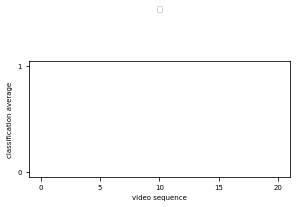

In [48]:
# Unreability score per query
dataQue0 = datQue[datQue['lab']=='clas']
plotCol(dataQue0, 'search', "sequences by search", "figures/figs9010" + str(filesufix2) + "_geralLines.eps")



### Analysis of bottom and top item video selection strategy

In [49]:
##
# Analysys by video selection stragegy 
# Use all dataset: dataSeqAvgAll
##

tmp0 = dataSeqAvgAll.groupby(['response']).mean().unstack()
tmp0 = pd.DataFrame(tmp0)
tmp0.reset_index(inplace=True) 
tmp0.columns = ['lab', 'bin', 'response', 'mean']

tmp1 = dataSeqAvgAll.groupby(['response']).std().unstack()
tmp1 = pd.DataFrame(tmp1)
tmp1.reset_index(inplace=True) 
tmp1.columns = ['lab','bin','response', 'std']

seqResponse = pd.merge(tmp0, tmp1, on=['lab','bin','response'], how='inner')
seqResponse['bin'] = np.where((seqResponse['bin']==0), 0 , seqResponse['bin']*BINSIZE )

tmp2 = dataSeqAvgAll.groupby(['response']).size()
tmp2 = pd.DataFrame(tmp2)
tmp2.reset_index(inplace=True) 
tmp2.columns = ['response', 'size']
seqResponse = pd.merge(seqResponse, tmp2, on=['response'], how='left')

seqResponse['sem'] = seqResponse.apply(lambda x: auxSem(x['std'], x['size']), axis=1)
seqResponse['sem'] = np.where((seqResponse['bin']==0), seqResponse['sem']*math.sqrt(BINSIZE), seqResponse['sem'])



0 0.67 0.67
0.15 0.8200000000000001 0.67
0.17999999999999994 0.85 0.67


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

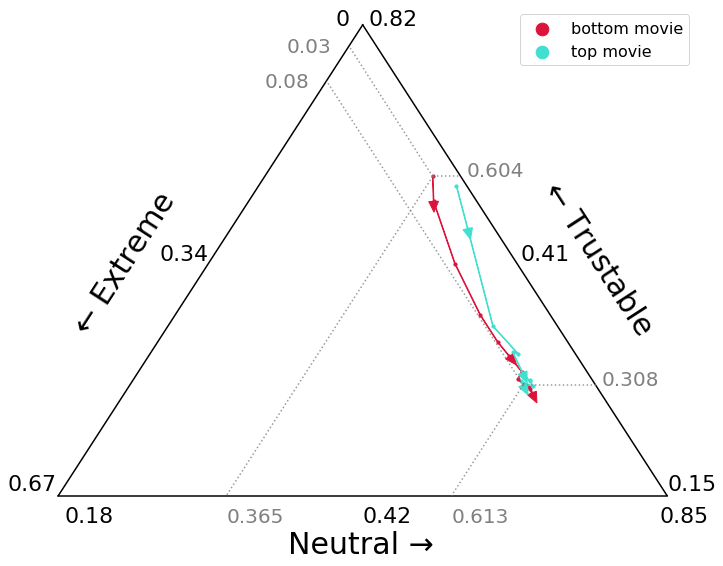

In [50]:
# Video Selection Strategy Ternary Plot 

scale = 0.67
mine = 0
mint = 0.15
maxt = mint + scale
minn = 1-maxt
maxn = 1-(mint)
maxe = 1-(mint+minn)
print(str(mine) + " " + str(maxe) + " " + str(maxe-mine))
print(str(mint) + " " + str(maxt) + " " + str(maxt-mint))
print(str(minn) + " " + str(maxn) + " " + str(maxn-minn))

# Auxiliary point to plot axis labels 
# P (neutral, trustable, extreme)
pu = (0,1, 0)
pl = (0, 0, 1)
pr = (1, 0, 0)
pmr = (0.5, 0.5, 0)
pmb = (0.5, 0, 0.5)
pml = (0, 0.5, 0.5)

# Fonts and text offset
fontsizeL = 30
fontsize1 = 22
fontsize2 = 20
off1 = 0.01
off2 = 0.012
off3 = 0.048
off4 = 0.054
off8 = off4*2+3*off2

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

for key, group in seqResponse.groupby('response'):
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        #print(b)
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=2
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            #plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016, head_length=0.02, fc=colorMap[key], ec=colorMap[key], label=key)
            if p == pointsS[1] or p == pointsS[-1] or p == pointsS[int(len(pointsS)/2)]:
                factor = 1
            else:
                factor = 0
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key], label=key)

        p0 = p
        i +=2

        
     
    # Plot initial and final guide lines    
    # P (neutral, trustable, extreme)

    if key == 'bottom movie':
        # Guide to initial point
        p0 = pointsS[0]
        pa0 = points0S[0]
        pp0 = project_point(p0)


        # extreme
        x = (p0[2])/2
        y = (p0[2])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off3), pp1[1]-y-off2, str(pa0[2]), color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str(pa0[1]), color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str(pa0[0]), color='gray', fontsize=fontsize2)

    if key == 'top movie':
        # Guide to final point   
        p0 = pointsS[-1]
        pa0 = points0S[-1]
        pp0 = project_point(p0)

        # extreme
        x = p0[2]/2
        y = p0[2]*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off3), pp1[1]-y-off2, str(pa0[2]), color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str(pa0[1]), color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str(pa0[0]), color='gray', fontsize=fontsize2)


# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2))), fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4+3*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2))), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2))), fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2))), fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2))), fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2))), fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4+3*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2))), fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2))), fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007"+ filesufix1 + "_responseTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()





bottom movie
[(0.365, 0.604, 0.03), (0.384, 0.569, 0.047), (0.451, 0.48, 0.068), (0.517, 0.407, 0.077), (0.555, 0.368, 0.077), (0.577, 0.349, 0.074), (0.602, 0.326, 0.072), (0.603, 0.315, 0.082), (0.621, 0.304, 0.075), (0.623, 0.302, 0.076), (0.628, 0.296, 0.076)]
top movie


No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artis

[(0.397, 0.591, 0.012), (0.44, 0.53, 0.03), (0.538, 0.391, 0.071), (0.585, 0.352, 0.063), (0.578, 0.354, 0.067), (0.604, 0.325, 0.072), (0.618, 0.312, 0.07), (0.617, 0.314, 0.068), (0.625, 0.305, 0.07), (0.608, 0.312, 0.079), (0.613, 0.308, 0.08)]
1 distance top-bot 0.07522632517942103
5 distance top-bot 0.037161808352124036
10 distance top-bot 0.020663978319771785


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


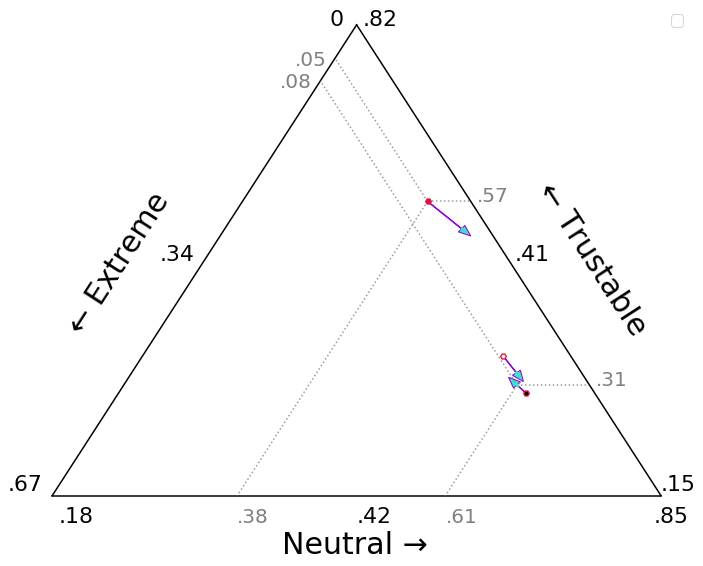

In [51]:
# Figure 6: Information Source Difference by Video Selection Strategy (bottom -> top)
# in time (initial, middle and end observation)

if len(dataYT['response'].unique()) > 1:

    # Ternary plot 
    figure, tax = ternary.figure(scale=1.0)
    figure.set_size_inches(12, 10)
    tax.boundary()
    #tax.gridlines(multiple=0.5, color="gray", alpha=0.9, linestyle=':')

    tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
    tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
    tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

    resPoint = []
    for key, group in seqResponse.groupby('response'):
        print(key)

        tmp0a = group[group['lab']=='clas']
        tmp0t = group[group['lab']=='clas-1']
        tmp0n = group[group['lab']=='clas0']
        tmp0e = group[group['lab']=='clas1']

        pointsS = []
        points0S = []
        for b in tmp0n.bin:
            #print(b)
            p0t = tmp0t[tmp0t['bin']== b]
            p0n = tmp0n[tmp0n['bin']== b]
            p0e = tmp0e[tmp0e['bin']== b]
            pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
            points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
        resPoint.append(pointsS)      
        print(points0S)


        # Plot initial and final guide lines    
        # P (neutral, trustable, extreme)


        if key == 'bottom movie':
            # Guide to initial point
            p0 = pointsS[1]
            pa0 = points0S[1]
            pp0 = project_point(p0)


            # extreme
            x = (p0[2])/2
            y = (p0[2])*math.sqrt(3)/2
            pp1 = project_point((0,1,0))
            plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

            # trustable
            x = (1-p0[1])/2
            y = (1-p0[1])*math.sqrt(3)/2
            pp1 = project_point((0,1,0))
            plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

            # neutral
            x = (p0[0])
            pp1 = project_point((0,0,1))
            plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

        if key == 'top movie':
            # Guide to final point   
            p0 = pointsS[-1]
            pa0 = points0S[-1]
            pp0 = project_point(p0)

            # extreme
            x = p0[2]/2
            y = p0[2]*math.sqrt(3)/2
            pp1 = project_point((0,1,0))
            plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

            # trustable
            x = (1-p0[1])/2
            y = (1-p0[1])*math.sqrt(3)/2
            pp1 = project_point((0,1,0))
            plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

            # neutral
            x = (p0[0])
            pp1 = project_point((0,0,1))
            plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)


    shapes =  ['left', 'right', 'full']
    i = 0
    for f in range(len(resPoint[0])):    
        pp0 = project_point(resPoint[0][f])
        pp1 = project_point(resPoint[1][f])
        if f == 1 or f == (len(resPoint[0])-1) or f == int(len(resPoint[0])/2):
            factor = 1
            shape = shapes[2]
            if f == 0:
                plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color=colorMap['top movie'], label='top movie')
                plt.plot(pp0[0], pp0[1], marker='o', markersize=3, color=colorMap['bottom movie'], label='bottom movie')
            else:
                plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color=colorMap['top movie'])
                plt.plot(pp0[0], pp0[1], marker='o', markersize=3, color=colorMap['bottom movie'])

            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap['top movie'], ec='darkviolet')
            print(str(f) + " distance top-bot " + str(eucliDistance2(pp0, pp1)))

            i += 1
        if f == 1:
            plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['bottom movie'])
        elif f == int(len(resPoint[0])/2):
            plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['bottom movie'])    
            plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='white')
        elif f == (len(resPoint[0])-1):
            plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['bottom movie'])    
            plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='black')
        #else:
        #    factor = 0
        #plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key], label=key)




    # Drawing re-scalled labels
    plt.axis('off')
    tax._redraw_labels()
    tax.legend(markerscale=4, fontsize=16)

    pp1 = project_point(pu)
    plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
    plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pl)
    plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
    plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pr)
    plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
    plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pmr)
    plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

    pp1 = project_point(pml)
    plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

    pp1 = project_point(pmb)
    plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)



    # Plotting and saving
    output =  "figures/fig007" + filesufix1 + "_responseDifTernary2.eps"
    fig = plt.gcf()
    fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
    tax.show()

bottom movie
[(0.365, 0.604, 0.03), (0.384, 0.569, 0.047), (0.451, 0.48, 0.068), (0.517, 0.407, 0.077), (0.555, 0.368, 0.077), (0.577, 0.349, 0.074), (0.602, 0.326, 0.072), (0.603, 0.315, 0.082), (0.621, 0.304, 0.075), (0.623, 0.302, 0.076), (0.628, 0.296, 0.076)]
top movie
[(0.397, 0.591, 0.012), (0.44, 0.53, 0.03), (0.538, 0.391, 0.071), (0.585, 0.352, 0.063), (0.578, 0.354, 0.067), (0.604, 0.325, 0.072), (0.618, 0.312, 0.07), (0.617, 0.314, 0.068), (0.625, 0.305, 0.07), (0.608, 0.312, 0.079), (0.613, 0.308, 0.08)]


No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artis

1 distance top-bot 0.07522632517942103
5 distance top-bot 0.037161808352124036


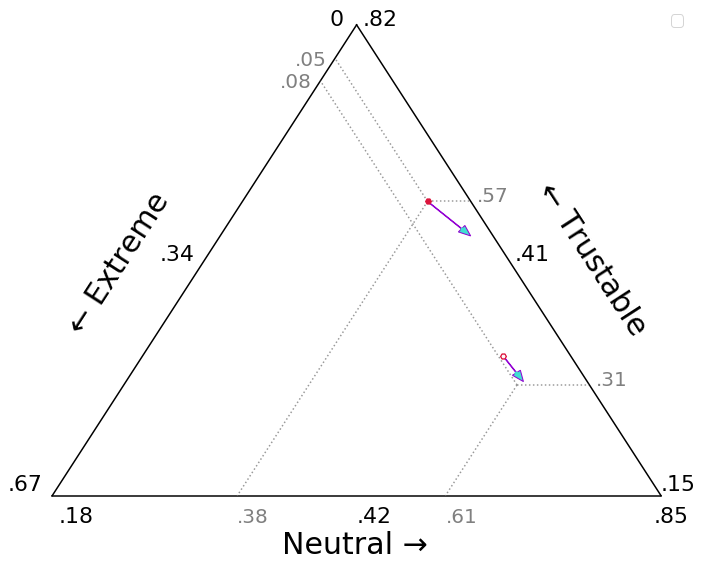

In [52]:
# Figure 6: Information Source Difference by Video Selection Strategy (bottom -> top)
# in time (initial, middle and end observation)

if len(dataYT['response'].unique()) > 1:

    # Ternary plot 
    figure, tax = ternary.figure(scale=1.0)
    figure.set_size_inches(12, 10)
    tax.boundary()
    #tax.gridlines(multiple=0.5, color="gray", alpha=0.9, linestyle=':')

    tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
    tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
    tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

    resPoint = []
    for key, group in seqResponse.groupby('response'):
        print(key)

        tmp0a = group[group['lab']=='clas']
        tmp0t = group[group['lab']=='clas-1']
        tmp0n = group[group['lab']=='clas0']
        tmp0e = group[group['lab']=='clas1']

        pointsS = []
        points0S = []
        for b in tmp0n.bin:
            #print(b)
            p0t = tmp0t[tmp0t['bin']== b]
            p0n = tmp0n[tmp0n['bin']== b]
            p0e = tmp0e[tmp0e['bin']== b]
            pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
            points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
        resPoint.append(pointsS)      
        print(points0S)


        # Plot initial and final guide lines    
        # P (neutral, trustable, extreme)


        if key == 'bottom movie':
            # Guide to initial point
            p0 = pointsS[1]
            pa0 = points0S[1]
            pp0 = project_point(p0)


            # extreme
            x = (p0[2])/2
            y = (p0[2])*math.sqrt(3)/2
            pp1 = project_point((0,1,0))
            plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

            # trustable
            x = (1-p0[1])/2
            y = (1-p0[1])*math.sqrt(3)/2
            pp1 = project_point((0,1,0))
            plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

            # neutral
            x = (p0[0])
            pp1 = project_point((0,0,1))
            plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

        if key == 'top movie':
            # Guide to final point   
            p0 = pointsS[-1]
            pa0 = points0S[-1]
            pp0 = project_point(p0)

            # extreme
            x = p0[2]/2
            y = p0[2]*math.sqrt(3)/2
            pp1 = project_point((0,1,0))
            plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

            # trustable
            x = (1-p0[1])/2
            y = (1-p0[1])*math.sqrt(3)/2
            pp1 = project_point((0,1,0))
            plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

            # neutral
            x = (p0[0])
            pp1 = project_point((0,0,1))
            plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)


    shapes =  ['left', 'right', 'full']
    i = 0
    for f in range(len(resPoint[0])):    
        pp0 = project_point(resPoint[0][f])
        pp1 = project_point(resPoint[1][f])
        if f == 1 or  f == int(len(resPoint[0])/2):
            factor = 1
            shape = shapes[2]
            if f == 0:
                plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color=colorMap['top movie'], label='top movie')
                plt.plot(pp0[0], pp0[1], marker='o', markersize=3, color=colorMap['bottom movie'], label='bottom movie')
            else:
                plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color=colorMap['top movie'])
                plt.plot(pp0[0], pp0[1], marker='o', markersize=3, color=colorMap['bottom movie'])

            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap['top movie'], ec='darkviolet')
            print(str(f) + " distance top-bot " + str(eucliDistance2(pp0, pp1)))

            i += 1
        if f == 1:
            plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['bottom movie'])
        elif f == int(len(resPoint[0])/2):
            plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['bottom movie'])    
            plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='white')
          #else:
        #    factor = 0
        #plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key], label=key)




    # Drawing re-scalled labels
    plt.axis('off')
    tax._redraw_labels()
    tax.legend(markerscale=4, fontsize=16)

    pp1 = project_point(pu)
    plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
    plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pl)
    plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
    plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pr)
    plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
    plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pmr)
    plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

    pp1 = project_point(pml)
    plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

    pp1 = project_point(pmb)
    plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)



    # Plotting and saving
    output =  "figures/fig007b" + filesufix1 + "_responseDifTernary2.eps"
    fig = plt.gcf()
    fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
    tax.show()

bottom movie
[(0.365, 0.604, 0.03), (0.384, 0.569, 0.047), (0.451, 0.48, 0.068), (0.517, 0.407, 0.077), (0.555, 0.368, 0.077), (0.577, 0.349, 0.074), (0.602, 0.326, 0.072), (0.603, 0.315, 0.082), (0.621, 0.304, 0.075), (0.623, 0.302, 0.076), (0.628, 0.296, 0.076)]
top movie


No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artis

[(0.397, 0.591, 0.012), (0.44, 0.53, 0.03), (0.538, 0.391, 0.071), (0.585, 0.352, 0.063), (0.578, 0.354, 0.067), (0.604, 0.325, 0.072), (0.618, 0.312, 0.07), (0.617, 0.314, 0.068), (0.625, 0.305, 0.07), (0.608, 0.312, 0.079), (0.613, 0.308, 0.08)]
1 distance top-bot 0.07522632517942103


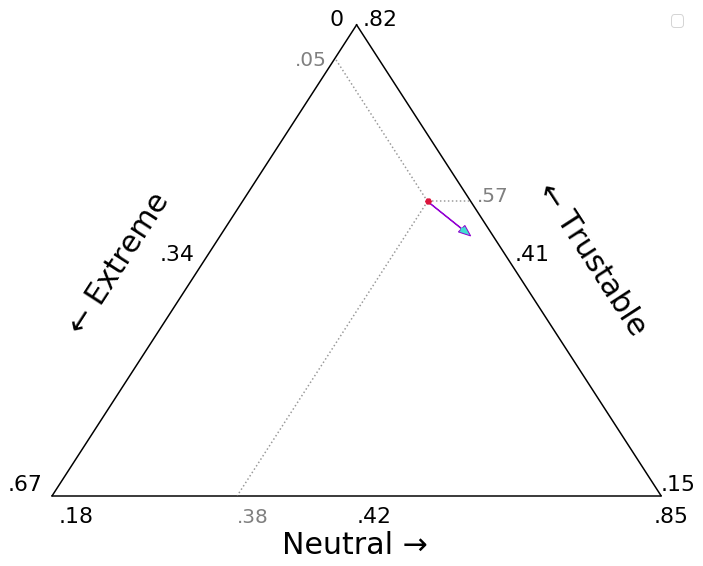

In [53]:
# Figure 6: Information Source Difference by Video Selection Strategy (bottom -> top)
# in time (initial, middle and end observation)

if len(dataYT['response'].unique()) > 1:

    # Ternary plot 
    figure, tax = ternary.figure(scale=1.0)
    figure.set_size_inches(12, 10)
    tax.boundary()
    #tax.gridlines(multiple=0.5, color="gray", alpha=0.9, linestyle=':')

    tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
    tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
    tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

    resPoint = []
    for key, group in seqResponse.groupby('response'):
        print(key)

        tmp0a = group[group['lab']=='clas']
        tmp0t = group[group['lab']=='clas-1']
        tmp0n = group[group['lab']=='clas0']
        tmp0e = group[group['lab']=='clas1']

        pointsS = []
        points0S = []
        for b in tmp0n.bin:
            #print(b)
            p0t = tmp0t[tmp0t['bin']== b]
            p0n = tmp0n[tmp0n['bin']== b]
            p0e = tmp0e[tmp0e['bin']== b]
            pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
            points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
        resPoint.append(pointsS)      
        print(points0S)


        # Plot initial and final guide lines    
        # P (neutral, trustable, extreme)


        if key == 'bottom movie':
            # Guide to initial point
            p0 = pointsS[1]
            pa0 = points0S[1]
            pp0 = project_point(p0)


            # extreme
            x = (p0[2])/2
            y = (p0[2])*math.sqrt(3)/2
            pp1 = project_point((0,1,0))
            plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

            # trustable
            x = (1-p0[1])/2
            y = (1-p0[1])*math.sqrt(3)/2
            pp1 = project_point((0,1,0))
            plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

            # neutral
            x = (p0[0])
            pp1 = project_point((0,0,1))
            plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
            plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

        

    shapes =  ['left', 'right', 'full']
    i = 0
    for f in range(len(resPoint[0])):    
        pp0 = project_point(resPoint[0][f])
        pp1 = project_point(resPoint[1][f])
        if f == 1 :
            factor = 1
            shape = shapes[2]
            if f == 0:
                plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color=colorMap['top movie'], label='top movie')
                plt.plot(pp0[0], pp0[1], marker='o', markersize=3, color=colorMap['bottom movie'], label='bottom movie')
            else:
                plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color=colorMap['top movie'])
                plt.plot(pp0[0], pp0[1], marker='o', markersize=3, color=colorMap['bottom movie'])

            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap['top movie'], ec='darkviolet')
            print(str(f) + " distance top-bot " + str(eucliDistance2(pp0, pp1)))

            i += 1
        if f == 1:
            plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap['bottom movie'])
          #else:
        #    factor = 0
        #plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key], label=key)




    # Drawing re-scalled labels
    plt.axis('off')
    tax._redraw_labels()
    tax.legend(markerscale=4, fontsize=16)

    pp1 = project_point(pu)
    plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
    plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pl)
    plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
    plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pr)
    plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
    plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pmr)
    plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

    pp1 = project_point(pml)
    plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

    pp1 = project_point(pmb)
    plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)



    # Plotting and saving
    output =  "figures/fig007a" + filesufix1 + "_responseDifTernary2.eps"
    fig = plt.gcf()
    fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
    tax.show()

In [54]:
## Analysis of video selection difference by scenearios of privacy

tmp0 = dataSeqAvgAll.groupby(['setting', 'response']).mean().unstack().unstack()
tmp0 = pd.DataFrame(tmp0)
tmp0.head()
tmp0.reset_index(inplace=True) 
tmp0.columns = ['lab', 'bin',  'response', 'setting', 'mean']
tmp0.head()

tmp1 = dataSeqAvgAll.groupby(['setting', 'response']).std().unstack().unstack()
tmp1 = pd.DataFrame(tmp1)
tmp1.reset_index(inplace=True) 
tmp1.columns = ['lab','bin','response', 'setting', 'std']

datSetRes = pd.merge(tmp0, tmp1, on=['lab','bin','setting','response'], how='inner')
datSetRes['bin'] = np.where((datSetRes['bin']==0), 0 , datSetRes['bin']*BINSIZE )

tmp2 = dataSeqAvgAll.groupby(['setting', 'response']).size()
tmp2 = pd.DataFrame(tmp2)
tmp2.reset_index(inplace=True) 
tmp2.columns = ['setting', 'response', 'size']
datSetRes = pd.merge(datSetRes, tmp2, on=['setting', 'response'], how='left')

datSetRes['sem'] = datSetRes.apply(lambda x: auxSem(x['std'], x['size']), axis=1)
datSetRes['sem'] = np.where((datSetRes['bin']==0), datSetRes['sem']*math.sqrt(BINSIZE), datSetRes['sem'])


logged
logged 1 distance 0.007937253933193793
(0.33, 0.639, 0.031)
(0.332, 0.643, 0.025)
0.0020000000000000018 0.0040000000000000036 -0.005999999999999998
logged 5 distance 0.1000149988751687
(0.473, 0.463, 0.064)
(0.424, 0.539, 0.037)
-0.04899999999999999 0.07600000000000001 -0.027000000000000003
logged 10 distance 0.1222333833287781
(0.498, 0.438, 0.064)
(0.424, 0.525, 0.051)
-0.07400000000000001 0.08700000000000002 -0.013000000000000005
normal
normal 1 distance 0.07518643494673757
(0.385, 0.547, 0.068)
(0.441, 0.531, 0.027)
0.055999999999999994 -0.016000000000000014 -0.04100000000000001
normal 5 distance 0.10812492774564061
(0.6, 0.33, 0.07)
(0.67, 0.256, 0.074)
0.07000000000000006 -0.07400000000000001 0.00399999999999999
normal 10 distance 0.06533758489567858
(0.645, 0.285, 0.07)
(0.68, 0.236, 0.084)
0.03500000000000003 -0.04899999999999999 0.013999999999999999
private
private 1 distance 0.16350229356189477
(0.348, 0.596, 0.057)
(0.469, 0.504, 0.027)
0.121 -0.09199999999999997 -0.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

tor 1 distance 0.07490660852021004
(0.473, 0.494, 0.033)
(0.52, 0.441, 0.039)
0.04700000000000004 -0.05299999999999999 0.005999999999999998
tor 5 distance 0.04099999999999993
(0.623, 0.301, 0.076)
(0.65, 0.273, 0.076)
0.027000000000000024 -0.02799999999999997 0.0
tor 10 distance 0.09822423326246935
(0.709, 0.215, 0.076)
(0.637, 0.271, 0.092)
-0.07199999999999995 0.05600000000000002 0.016


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

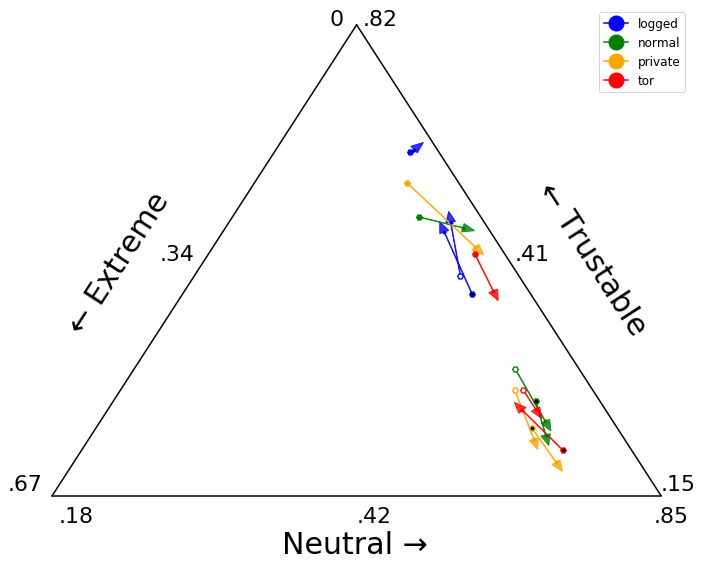

In [55]:
## 
# Figure 7: Information Source Difference by Video Selection Strategy (bottom -> top)
# in time (initial, middle and end observation) per Privacy Scenarios

if len(dataYT['response'].unique()) > 1:
    # Ternary plot 
    figure, tax = ternary.figure(scale=1.0)
    figure.set_size_inches(12, 10)
    tax.boundary()
  
    tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
    tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
    tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)
    #tax.set_title("Categories proportion over video sequence", fontsize=fontsizeL)




    for key0, groupS in datSetRes.groupby('setting'):
        print(key0)


        resPoint = []
        resPointR = []
        for key, group in groupS.groupby('response'):
            #print(key)

            tmp0a = group[group['lab']=='clas']
            tmp0t = group[group['lab']=='clas-1']
            tmp0n = group[group['lab']=='clas0']
            tmp0e = group[group['lab']=='clas1']

            #print(tmp00.bin)
            points = []
            pointsR = []
            for b in tmp0n.bin:
                #print(b)
                p0t = tmp0t[tmp0t['bin']== b]
                p0n = tmp0n[tmp0n['bin']== b]
                p0e = tmp0e[tmp0e['bin']== b]
                #print(float(round(p00['mean'],3)))
                pointsR.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)),float(round(p0e['mean'],3)) ))
                points.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
            #print(points)
            resPointR.append(pointsR)
            resPoint.append(points)


        #tax.scatter(resPoint[0], color=colorMap[key0], label=key0, s=5)    



        i = 0
        for f in range(len(resPoint[0])):    
        #for p in pointsR:
            pp0 = project_point(resPoint[0][f])
            pp1 = project_point(resPoint[1][f])
            if f == 1 or f == (len(resPoint[0])-1) or f == int(len(resPoint[0])/2):
                factor = 1
                plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key0], ec=colorMap[key0], alpha=0.8)
                print(str(key0) + " " + str(f) + " distance " + str(eucliDistance2(pp0, pp1)))
                print(resPointR[0][f])
                print(resPointR[1][f])
                a = resPointR[0][f]
                b = resPointR[1][f]
                print(str(b[0]-a[0]) + " " + str(b[1]-a[1]) + " " + str(b[2]-a[2]))


                if f == 1:
                    plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color=colorMap[key0], label=key0)
                    plt.plot(pp0[0], pp0[1], marker='o', markersize=3, color=colorMap[key0])
                else:
                    plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color=colorMap[key0])
                    plt.plot(pp0[0], pp0[1], marker='o', markersize=3, color=colorMap[key0])

                if f == 1:
                    plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap[key0])
                elif f == int(len(resPoint[0])/2):
                    plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap[key0])    
                    plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='white')
                elif f == (len(resPoint[0])-1):
                    plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap[key0])    
                    plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='black')

                i +=1
    # Drawing re-scalled labels
    plt.axis('off')
    tax._redraw_labels()

    pp1 = project_point(pu)
    plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
    plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pl)
    plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
    plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pr)
    plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
    plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pmr)
    plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

    pp1 = project_point(pml)
    plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

    pp1 = project_point(pmb)
    plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)



    tax.legend(markerscale=5, fontsize=12)


    output =  "figures/fig007"+ filesufix1 + "_responseDifSetAllTernary.eps"
    figure.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
    tax.show()    

### Analysis before and after YouTube's policy change 

In [56]:
###
# Analysis by real time 

# Getting unreability score for whole sequence
dataWhole = dataYTPol.groupby(['search', 'setting', 'preaction', 'response','date', 'filename', 'pol'])['clas'].mean()
dataWhole = pd.DataFrame(dataWhole)
dataWhole.reset_index(inplace=True)



In [57]:
# Top item strategy
dataWholeTop = dataWhole[dataWhole.response == 'top movie']

dataWholeTop = dataWholeTop.sort_values(by=['date'])
dataWholeTop.reset_index(inplace=True)
dataWholeTop = dataWholeTop.sort_values(by=['date'])
dataWholeTop.reset_index(inplace=True)
dataWholeTop['tmp'] = dataWholeTop.index

# creating zero point of after policy change
minTmp = dataWholeTop[dataWholeTop['pol'] == 'after']['tmp'].min()
dataWholeTop['count2'] = dataWholeTop['tmp']-minTmp+1

BSIZE = 20
dataWholeTop['date sequence'] = dataWholeTop.apply(lambda x: int(int(x['count2']-1)/BSIZE), axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


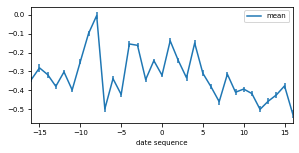

In [58]:
# Figure 11: Unreability Score over Date Sequence

tmp01 = dataWholeTop.groupby(['date sequence'])['clas'].mean()
tmp01 = pd.DataFrame(tmp01)
tmp01.reset_index(inplace=True) 
tmp01.columns = ['date sequence', 'mean']

tmp02 = dataWholeTop.groupby(['date sequence'])['clas'].std()
tmp02 = pd.DataFrame(tmp02)
tmp02.reset_index(inplace=True) 
tmp02.columns = ['date sequence','std']

seqOverall = pd.merge(tmp01, tmp02, on=['date sequence'], how='inner')


seqOverall['sem'] = seqOverall.apply(lambda x: auxSem(x['std'], BSIZE*20), axis=1)

fig, ax = plt.subplots(figsize=(4,2))   # 1
plt.rc('font', size=7)
seqOverall['date sequence'] = seqOverall['date sequence'].astype(int)
#ax.set_xlim(1, 21)
ax.locator_params(integer=True)

fig.tight_layout()

tmp03 = seqOverall.copy()
tmp03.plot('date sequence', 'mean', yerr='sem', ax=ax)
fig.savefig("figures/fig007"+ filesufix3 + "Top_dateBinClas.eps", format='eps', bbox_inches='tight', pad_inches=0.01)


In [59]:
# Getting data sequence average data per bin
dataSeqAvgPol = dataYTPol.groupby(['search', 'setting', 'preaction', 'response','date', 'filename','pol','bin'])['clas','clas-1', 'clas0', 'clas1'].mean().unstack().fillna(0)
dataSeqAvgPol = pd.DataFrame(dataSeqAvgPol)
dataSeqAvgPol.reset_index(inplace=True)

# Top item strategy
dataSeqAvgPolTop = dataSeqAvgPol[dataSeqAvgPol.response == 'top movie']

In [60]:
##
# Overall analysis before and after change 
##

tmp0 = dataSeqAvgPolTop.groupby(['pol']).mean().unstack()
tmp0 = pd.DataFrame(tmp0)
tmp0.reset_index(inplace=True) 
tmp0.columns = ['lab', 'bin', 'pol', 'mean']

tmp1 = dataSeqAvgPolTop.groupby(['pol']).std().unstack()
tmp1 = pd.DataFrame(tmp1)
tmp1.reset_index(inplace=True) 
tmp1.columns = ['lab','bin','pol', 'std']

seqResponse = pd.merge(tmp0, tmp1, on=['lab','bin','pol'], how='inner')
seqResponse['bin'] = np.where((seqResponse['bin']==0), 0 , seqResponse['bin']*BINSIZE )

tmp2 = dataSeqAvgPolTop.groupby(['pol']).size()
tmp2 = pd.DataFrame(tmp2)
tmp2.reset_index(inplace=True) 
tmp2.columns = ['pol', 'size']
seqResponse = pd.merge(seqResponse, tmp2, on=['pol'], how='left')

seqResponse['sem'] = seqResponse.apply(lambda x: auxSem(x['std'], x['size']), axis=1)
seqResponse['sem'] = np.where((seqResponse['bin']==0), seqResponse['sem']*math.sqrt(BINSIZE), seqResponse['sem'])




/Users/larissapspinelli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


after
[(0.448, 0.546, 0.006), (0.481, 0.503, 0.015), (0.545, 0.412, 0.043), (0.549, 0.404, 0.046), (0.534, 0.401, 0.065), (0.552, 0.383, 0.065), (0.557, 0.387, 0.056), (0.577, 0.363, 0.06), (0.579, 0.355, 0.066), (0.573, 0.366, 0.062), (0.556, 0.38, 0.065)]
before


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[(0.324, 0.664, 0.012), (0.381, 0.577, 0.042), (0.511, 0.398, 0.091), (0.534, 0.392, 0.074), (0.554, 0.355, 0.091), (0.594, 0.316, 0.09), (0.603, 0.302, 0.094), (0.611, 0.312, 0.077), (0.622, 0.293, 0.085), (0.617, 0.284, 0.099), (0.619, 0.284, 0.097)]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


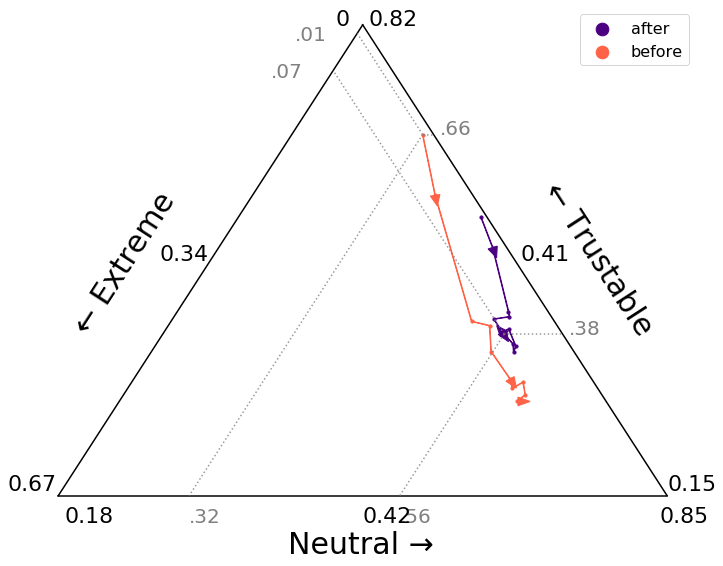

In [61]:
##
# Figure 12a: classification proportions shifts before and after


# Ternary plot 
figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

for key, group in seqResponse.groupby('pol'):
    print(key)
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
    print(points0S)       
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=2
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            #plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016, head_length=0.02, fc=colorMap[key], ec=colorMap[key], label=key)
            if p == pointsS[1] or p == pointsS[-1] or p == pointsS[int(len(pointsS)/2)]:
                factor = 1
            else:
                factor = 0
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key], label=key)

        p0 = p
        i +=2

        
     
    # Plot initial and final guide lines    
    # P (neutral, trustable, extreme)

    if key == 'before':
        # Guide to initial point
        p0 = pointsS[0]
        pa0 = points0S[0]
        pp0 = project_point(p0)


        # extreme
        x = (p0[2])/2
        y = (p0[2])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off3), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

    if key == 'after':
        # Guide to final point   
        p0 = pointsS[-1]
        pa0 = points0S[-1]
        pp0 = project_point(p0)

        # extreme
        x = p0[2]/2
        y = p0[2]*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off3), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)


# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2))), fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4+3*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2))), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2))), fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2))), fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2))), fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2))), fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4+3*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2))), fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2))), fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007"+ filesufix3 + "Top_responseTime.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()

In [62]:
tmp0 = dataSeqAvgPol.groupby(['pol', 'response']).mean().unstack().unstack()
tmp0 = pd.DataFrame(tmp0)
tmp0.head()
tmp0.reset_index(inplace=True) 
tmp0.columns = ['lab', 'bin',  'response', 'pol', 'mean']
tmp0.head()

tmp1 = dataSeqAvgPol.groupby(['pol', 'response']).std().unstack().unstack()
tmp1 = pd.DataFrame(tmp1)
tmp1.reset_index(inplace=True) 
tmp1.columns = ['lab','bin','response', 'pol', 'std']

datSetPol = pd.merge(tmp0, tmp1, on=['lab','bin','pol','response'], how='inner')
datSetPol['bin'] = np.where((datSetPol['bin']==0), 0 , datSetPol['bin']*BINSIZE )

tmp2 = dataSeqAvgPol.groupby(['pol', 'response']).size()
tmp2 = pd.DataFrame(tmp2)
tmp2.reset_index(inplace=True) 
tmp2.columns = ['pol', 'response', 'size']
datSetPol = pd.merge(datSetPol, tmp2, on=['pol', 'response'], how='left')

datSetPol['sem'] = datSetPol.apply(lambda x: auxSem(x['std'], x['size']), axis=1)
datSetPol['sem'] = np.where((datSetPol['bin']==0), datSetPol['sem']*math.sqrt(BINSIZE), datSetPol['sem'])



after
after 1 distance 0.06173329733620257
(0.434, 0.531, 0.035)
(0.481, 0.503, 0.015)
0.046999999999999986 -0.028000000000000025 -0.020000000000000004
after 5 distance 0.05716642371182577
(0.583, 0.34, 0.077)
(0.552, 0.383, 0.065)
-0.030999999999999917 0.04299999999999998 -0.011999999999999997
after 10 distance 0.14960949167750015
(0.648, 0.273, 0.079)
(0.556, 0.38, 0.065)
-0.09199999999999997 0.10699999999999998 -0.013999999999999999
before


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

before 1 distance 0.07274613391789282
(0.329, 0.622, 0.049)
(0.381, 0.577, 0.042)
0.05199999999999999 -0.04500000000000004 -0.006999999999999999
before 5 distance 0.09789279850938981
(0.545, 0.39, 0.065)
(0.594, 0.316, 0.09)
0.04899999999999993 -0.07400000000000001 0.024999999999999994
before 10 distance 0.019052558883257704
(0.627, 0.292, 0.082)
(0.619, 0.284, 0.097)
-0.008000000000000007 -0.008000000000000007 0.015


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

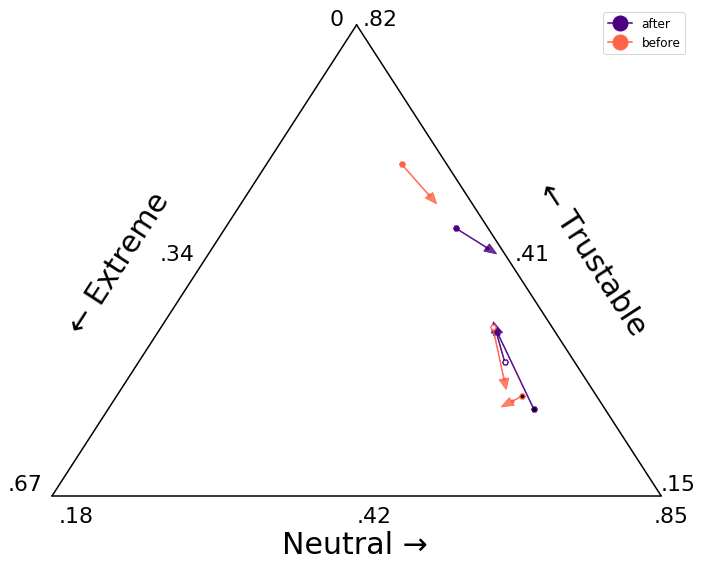

In [63]:
##
# Figure 12b: video selection strategy difference (bottom -> top)
# in time (initial, middle and end observation)


if len(dataYTPol['pol'].unique()) > 1:
    # Ternary plot 
    figure, tax = ternary.figure(scale=1.0)
    figure.set_size_inches(12, 10)
    tax.boundary()
    #tax.gridlines(multiple=0.5, color="gray", alpha=0.9, linestyle=':')

    tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
    tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
    tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)
    #tax.set_title("Categories proportion over video sequence", fontsize=fontsizeL)




    for key0, groupS in datSetPol.groupby('pol'):
        print(key0)


        resPoint = []
        resPointR = []
        for key, group in groupS.groupby('response'):
            #print(key)

            tmp0a = group[group['lab']=='clas']
            tmp0t = group[group['lab']=='clas-1']
            tmp0n = group[group['lab']=='clas0']
            tmp0e = group[group['lab']=='clas1']

            #print(tmp00.bin)
            points = []
            pointsR = []
            for b in tmp0n.bin:
                #print(b)
                p0t = tmp0t[tmp0t['bin']== b]
                p0n = tmp0n[tmp0n['bin']== b]
                p0e = tmp0e[tmp0e['bin']== b]
                #print(float(round(p00['mean'],3)))
                pointsR.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)),float(round(p0e['mean'],3)) ))
                points.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
            #print(points)
            resPointR.append(pointsR)
            resPoint.append(points)


        #tax.scatter(resPoint[0], color=colorMap[key0], label=key0, s=5)    



        i = 0
        for f in range(len(resPoint[0])):    
        #for p in pointsR:
            pp0 = project_point(resPoint[0][f])
            pp1 = project_point(resPoint[1][f])
            if f == 1 or f == (len(resPoint[0])-1) or f == int(len(resPoint[0])/2):
                factor = 1
                plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key0], ec=colorMap[key0], alpha=0.8)
                print(str(key0) + " " + str(f) + " distance " + str(eucliDistance2(pp0, pp1)))
                print(resPointR[0][f])
                print(resPointR[1][f])
                a = resPointR[0][f]
                b = resPointR[1][f]
                print(str(b[0]-a[0]) + " " + str(b[1]-a[1]) + " " + str(b[2]-a[2]))


                if f == 1:
                    plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color=colorMap[key0], label=key0)
                    plt.plot(pp0[0], pp0[1], marker='o', markersize=3, color=colorMap[key0])
                else:
                    plt.plot(pp1[0], pp1[1], marker='o', markersize=3, color=colorMap[key0])
                    plt.plot(pp0[0], pp0[1], marker='o', markersize=3, color=colorMap[key0])

                if f == 1:
                    plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap[key0])
                elif f == int(len(resPoint[0])/2):
                    plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap[key0])    
                    plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='white')
                elif f == (len(resPoint[0])-1):
                    plt.plot(pp0[0], pp0[1], marker='H', markersize=6, color=colorMap[key0])    
                    plt.plot(pp0[0], pp0[1], marker='H', markersize=3, color='black')

                i +=1
    # Drawing re-scalled labels
    plt.axis('off')
    tax._redraw_labels()

    pp1 = project_point(pu)
    plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
    plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pl)
    plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
    plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pr)
    plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
    plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

    pp1 = project_point(pmr)
    plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

    pp1 = project_point(pml)
    plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

    pp1 = project_point(pmb)
    plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)



    tax.legend(markerscale=5, fontsize=12)


    output =  "figures/fig007"+ filesufix3 + "_responseDifSetTime.eps"
    figure.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
    tax.show()    

In [64]:
# Before analysis by Scenarios of Privacy

dataSeqAvgPol0 = dataSeqAvgPol[dataSeqAvgPol.pol == 'before']

## 
# Analysis per scenarios of privacy (before)
##

tmp0 = dataSeqAvgPol0.groupby(['setting']).mean().unstack()
tmp0 = pd.DataFrame(tmp0)
tmp0.reset_index(inplace=True) 
tmp0.columns = ['lab', 'bin', 'setting', 'mean']

tmp1 = dataSeqAvgPol0.groupby(['setting']).std().unstack()
tmp1 = pd.DataFrame(tmp1)
tmp1.reset_index(inplace=True) 
tmp1.columns = ['lab','bin','setting', 'std']

seqSettings = pd.merge(tmp0, tmp1, on=['lab','bin','setting'], how='inner')
seqSettings['bin'] = np.where((seqSettings['bin']==0), 0 , seqSettings['bin']*BINSIZE )

tmp2 = dataSeqAvgPol0.groupby(['setting']).size()
tmp2 = pd.DataFrame(tmp2)
tmp2.reset_index(inplace=True) 
tmp2.columns = ['setting', 'size']
seqSettings = pd.merge(seqSettings, tmp2, on=['setting'], how='left')

seqSettings['sem'] = seqSettings.apply(lambda x: auxSem(x['std'], x['size']), axis=1)
seqSettings['sem'] = np.where((seqSettings['bin']==0), seqSettings['sem']*math.sqrt(BINSIZE), seqSettings['sem'])



logged (ternary points):
[(0.309, 0.66, 0.031), (0.29, 0.667, 0.043), (0.302, 0.654, 0.043), (0.33, 0.62, 0.049), (0.346, 0.62, 0.034), (0.386, 0.59, 0.025), (0.401, 0.556, 0.043), (0.377, 0.599, 0.025), (0.392, 0.568, 0.04), (0.41, 0.546, 0.043), (0.395, 0.559, 0.046)]
normal (ternary points):
[(0.265, 0.716, 0.019), (0.343, 0.608, 0.049), (0.472, 0.435, 0.093), (0.528, 0.398, 0.074), (0.614, 0.281, 0.105), (0.667, 0.25, 0.083), (0.639, 0.275, 0.086), (0.63, 0.287, 0.083), (0.654, 0.241, 0.105), (0.676, 0.231, 0.093), (0.657, 0.219, 0.123)]
private (ternary points):
[(0.315, 0.673, 0.012), (0.34, 0.605, 0.056), (0.485, 0.392, 0.123), (0.54, 0.336, 0.123), (0.559, 0.318, 0.123), (0.593, 0.287, 0.12), (0.648, 0.253, 0.099), (0.648, 0.225, 0.127), (0.667, 0.225, 0.108), (0.657, 0.219, 0.123), (0.716, 0.179, 0.105)]
tor (ternary points):
[(0.414, 0.58, 0.006), (0.448, 0.519, 0.034), (0.556, 0.367, 0.077), (0.59, 0.33, 0.08), (0.565, 0.352, 0.083), (0.633, 0.287, 0.08), (0.642, 0.256, 0.10

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

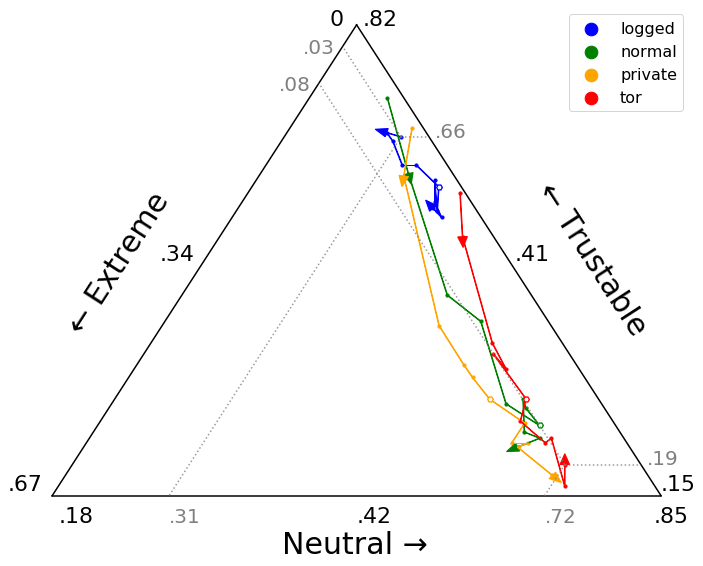

In [65]:
# Ternary plot: Information Sources on Sequences of Recommendation per Privacy Scenarios
# Figure 13a - before policy change

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

dis003 = []
dis002 = []
my_dic = {}
for key, group in seqSettings.groupby('setting'):
    print(str(key) + " (ternary points):")
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=0
    dis03 = []
    dis02 = []
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            if p == pointsS[1] or p == pointsS[-1] :
                factor = 1
            
            
            else:
                factor = 0
                if p == pointsS[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color=colorMap[key])
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key])
            d3 = eucliDistance3(p0, p)
            d2 = eucliDistance2(pp0, pp1)
            #print(str(key) + " " + str(i) + " distance " + str(d2))
            i += 1
            dis03.append(d3)
            dis02.append(d2)
        p0 = p
    
    my_dic[key] = dis03
    dis003.append(dis03)
    dis002.append(dis02)

        
    if key == 'logged' : 
        # Plot initial and final guide lines    
        # P (neutral, trustable, extreme)

        # Guide to initial point
        p0 = pointsS[0]
        pa0 = points0S[0]
        pp0 = project_point(p0)

        # extreme
        x = (p0[2])/2
        y = (p0[2])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

    if key == 'tor': 
        # Guide to final point   
        p0 = pointsS[-1]
        pa0 = points0S[-1]
        pp0 = project_point(p0)

        # extreme
        x = p0[2]/2
        y = p0[2]*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007" + filesufix3 + "0_settingTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()





In [66]:
# After analysis by Scenarios of Privacy

dataSeqAvgPol0 = dataSeqAvgPol[dataSeqAvgPol.pol == 'after']

## 
# Analysis per scenarios of privacy (after)
##

tmp0 = dataSeqAvgPol0.groupby(['setting']).mean().unstack()
tmp0 = pd.DataFrame(tmp0)
tmp0.reset_index(inplace=True) 
tmp0.columns = ['lab', 'bin', 'setting', 'mean']

tmp1 = dataSeqAvgPol0.groupby(['setting']).std().unstack()
tmp1 = pd.DataFrame(tmp1)
tmp1.reset_index(inplace=True) 
tmp1.columns = ['lab','bin','setting', 'std']

seqSettings = pd.merge(tmp0, tmp1, on=['lab','bin','setting'], how='inner')
seqSettings['bin'] = np.where((seqSettings['bin']==0), 0 , seqSettings['bin']*BINSIZE )

tmp2 = dataSeqAvgPol0.groupby(['setting']).size()
tmp2 = pd.DataFrame(tmp2)
tmp2.reset_index(inplace=True) 
tmp2.columns = ['setting', 'size']
seqSettings = pd.merge(seqSettings, tmp2, on=['setting'], how='left')

seqSettings['sem'] = seqSettings.apply(lambda x: auxSem(x['std'], x['size']), axis=1)
seqSettings['sem'] = np.where((seqSettings['bin']==0), seqSettings['sem']*math.sqrt(BINSIZE), seqSettings['sem'])




logged (ternary points):
[(0.346, 0.654, 0.0), (0.37, 0.627, 0.003), (0.417, 0.552, 0.031), (0.438, 0.537, 0.025), (0.506, 0.457, 0.037), (0.509, 0.438, 0.052), (0.472, 0.457, 0.071), (0.466, 0.469, 0.065), (0.497, 0.423, 0.08), (0.491, 0.438, 0.071), (0.525, 0.423, 0.052)]
normal (ternary points):
[(0.451, 0.512, 0.037), (0.478, 0.478, 0.043), (0.565, 0.367, 0.068), (0.59, 0.346, 0.065), (0.565, 0.346, 0.09), (0.565, 0.34, 0.096), (0.602, 0.343, 0.056), (0.608, 0.318, 0.074), (0.605, 0.293, 0.102), (0.639, 0.275, 0.086), (0.642, 0.287, 0.071)]
private (ternary points):
[(0.432, 0.543, 0.025), (0.466, 0.497, 0.037), (0.565, 0.389, 0.046), (0.58, 0.358, 0.062), (0.608, 0.318, 0.074), (0.59, 0.33, 0.08), (0.574, 0.34, 0.086), (0.605, 0.312, 0.083), (0.599, 0.315, 0.086), (0.596, 0.312, 0.093), (0.562, 0.327, 0.111)]
tor (ternary points):


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[(0.488, 0.5, 0.012), (0.515, 0.466, 0.019), (0.559, 0.383, 0.059), (0.571, 0.355, 0.074), (0.59, 0.346, 0.065), (0.608, 0.336, 0.056), (0.617, 0.321, 0.062), (0.645, 0.281, 0.074), (0.67, 0.275, 0.056), (0.673, 0.284, 0.043), (0.679, 0.269, 0.052)]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

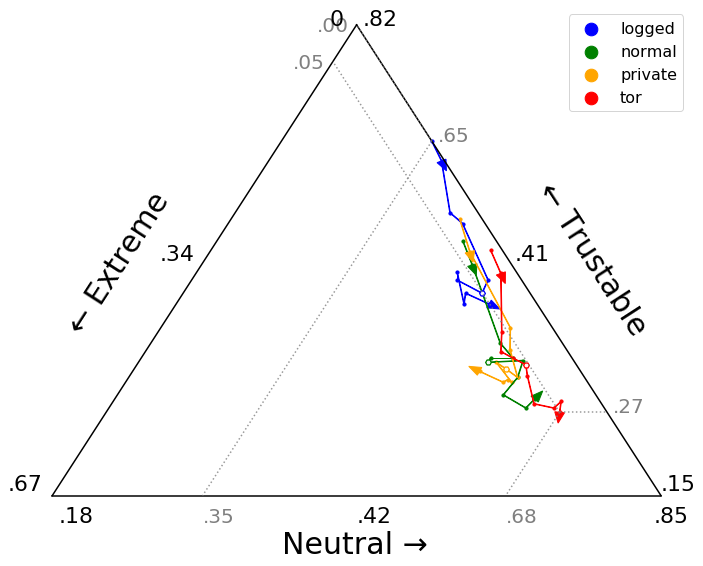

In [67]:
# Ternary plot: Information Sources on Sequences of Recommendation per Privacy Scenarios
# Figure 13b - after policy change

figure, tax = ternary.figure(scale=1.0)
figure.set_size_inches(12, 10)
tax.boundary()

tax.left_axis_label("\u2190 Extreme", fontsize=fontsizeL, offset=(off8))
tax.right_axis_label("\u2190 Trustable ", fontsize=fontsizeL, offset=(off8))
tax.bottom_axis_label("Neutral \u2192", fontsize=fontsizeL, offset=off2)

dis003 = []
dis002 = []
my_dic = {}
for key, group in seqSettings.groupby('setting'):
    print(str(key) + " (ternary points):")
    
    tmp0a = group[group['lab']=='clas']
    tmp0t = group[group['lab']=='clas-1']
    tmp0n = group[group['lab']=='clas0']
    tmp0e = group[group['lab']=='clas1']
    
    pointsS = []
    points0S = []
    for b in tmp0n.bin:
        p0t = tmp0t[tmp0t['bin']== b]
        p0n = tmp0n[tmp0n['bin']== b]
        p0e = tmp0e[tmp0e['bin']== b]
        pointsS.append((float(round((p0n['mean']-minn)/scale,3)),float(round((p0t['mean']-mint)/scale,3)),float(round((p0e['mean']-mine)/scale,3)) ))
        points0S.append((float(round(p0n['mean'],3)),float(round(p0t['mean'],3)), float(round(p0e['mean'],3))))
           
    print(points0S)
    tax.scatter(pointsS, color=colorMap[key], label=key, s=10)
    p0 = (0,0,0)
    i=0
    dis03 = []
    dis02 = []
    for p in pointsS:
        pp1 = project_point(p)
        if p0 != (0,0,0):
            pp0 = project_point(p0)
            if p == pointsS[1] or p == pointsS[-1] :
                factor = 1
            
            
            else:
                factor = 0
                if p == pointsS[int(len(points)/2)]:
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=6, color=colorMap[key])
                    plt.plot(pp1[0], pp1[1], marker='H', markersize=3, color='white')
            plt.arrow(pp0[0], pp0[1], pp1[0]-pp0[0], pp1[1]-pp0[1], head_width=0.016*factor, head_length=0.02*factor, fc=colorMap[key], ec=colorMap[key])
            d3 = eucliDistance3(p0, p)
            d2 = eucliDistance2(pp0, pp1)
            #print(str(key) + " " + str(i) + " distance " + str(d2))
            i += 1
            dis03.append(d3)
            dis02.append(d2)
        p0 = p
    
    my_dic[key] = dis03
    dis003.append(dis03)
    dis002.append(dis02)

        
    if key == 'logged' : 
        # Plot initial and final guide lines    
        # P (neutral, trustable, extreme)

        # Guide to initial point
        p0 = pointsS[0]
        pa0 = points0S[0]
        pp0 = project_point(p0)

        # extreme
        x = (p0[2])/2
        y = (p0[2])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

    if key == 'tor': 
        # Guide to final point   
        p0 = pointsS[-1]
        pa0 = points0S[-1]
        pp0 = project_point(p0)

        # extreme
        x = p0[2]/2
        y = p0[2]*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]-x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]-x-(off4+off2), pp1[1]-y-off2, str("{:.2f}".format(round(pa0[2],2)))[1:], color='gray', fontsize=fontsize2)

        # trustable
        x = (1-p0[1])/2
        y = (1-p0[1])*math.sqrt(3)/2
        pp1 = project_point((0,1,0))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]-y], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x+off1, pp1[1]-y, str("{:.2f}".format(round(pa0[1],2)))[1:], color='gray', fontsize=fontsize2)

        # neutral
        x = (p0[0])
        pp1 = project_point((0,0,1))
        plt.plot([pp0[0], pp1[0]+x],[pp0[1], pp1[1]], color='gray', linestyle=':', alpha=.8)
        plt.text(pp1[0]+x, pp1[1]-off3, str("{:.2f}".format(round(pa0[0],2)))[1:], color='gray', fontsize=fontsize2)

# Drawing re-scalled labels
plt.axis('off')
tax._redraw_labels()
tax.legend(markerscale=4, fontsize=16)

pp1 = project_point(pu)
plt.text(pp1[0]-off4+off1, pp1[1], str(round(mine,2)), fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pl)
plt.text(pp1[0]-(off4+2*off1), pp1[1]+off1, str("{:.2f}".format(round((mine+scale),2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]+off1, pp1[1]-off3, str("{:.2f}".format(round(minn,2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pr)
plt.text(pp1[0], pp1[1]+off1, str("{:.2f}".format(round(mint,2)))[1:], fontsize=fontsize1)
plt.text(pp1[0]-off2, pp1[1]-off3, str("{:.2f}".format(round((minn+scale),2)))[1:], fontsize=fontsize1)        

pp1 = project_point(pmr)
plt.text(pp1[0]+off1, pp1[1], str("{:.2f}".format(round((mint+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pml)
plt.text(pp1[0]-(off4+2*off1), pp1[1], str("{:.2f}".format(round((mine+scale)/2,2)))[1:], fontsize=fontsize1)

pp1 = project_point(pmb)
plt.text(pp1[0], pp1[1]-off3, str("{:.2f}".format(round((minn+scale)/2,2)))[1:], fontsize=fontsize1)


# Plotting and saving
output =  "figures/fig007" + filesufix3 + "1_settingTernary.eps"
fig = plt.gcf()
fig.savefig(output, format='eps', bbox_inches='tight', pad_inches=0)
tax.show()




